In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
6    4684
0    4684
5    4684
1    4684
8    4684
2    4684
7    4684
4    4684
3    4684
9    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


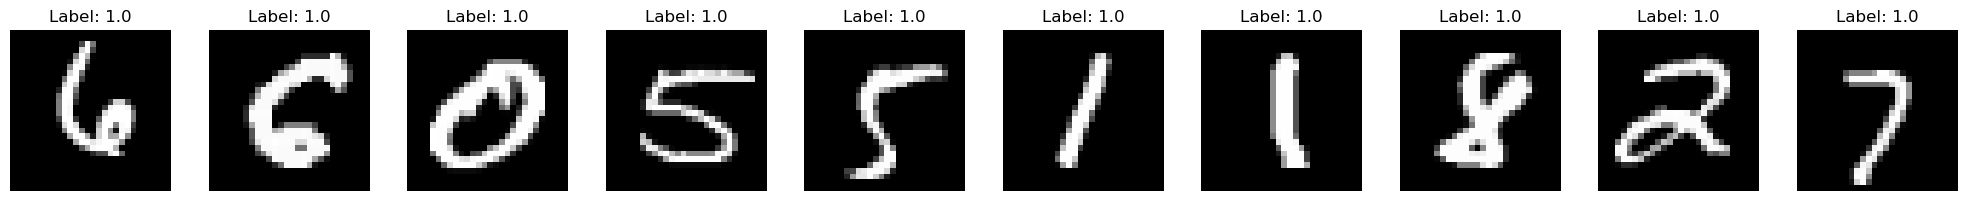

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|█████████████████████████████████████████████████████| 732/732 [00:25<00:00, 29.17it/s, loss_D=0.958, loss_G=1.41]


Epoch [1/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [1/400] - Average D loss: 0.9951, Average G loss: 1.2726


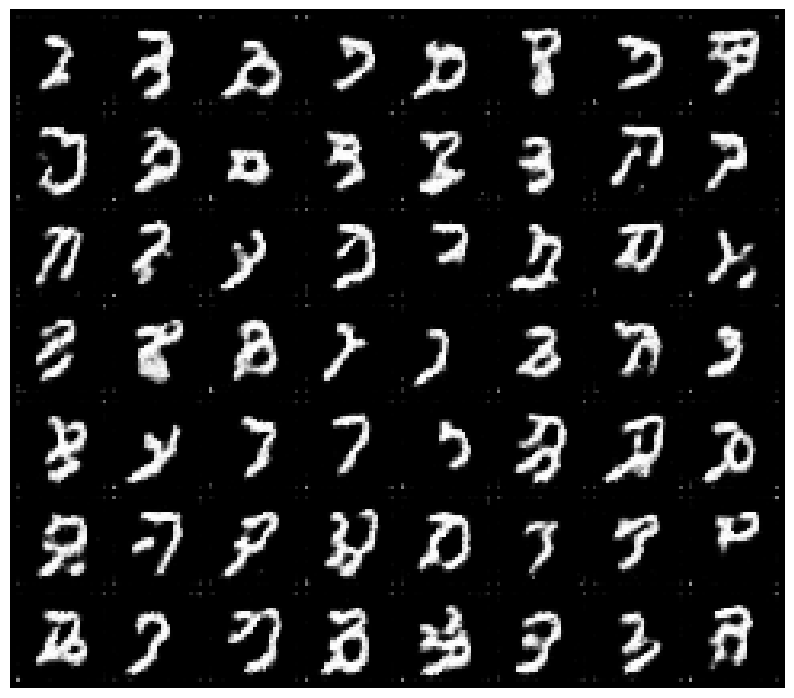

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.28it/s, loss_D=1.18, loss_G=1.07]


Epoch [2/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [2/400] - Average D loss: 1.1207, Average G loss: 1.0134


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=1.11, loss_G=1.04]


Epoch [3/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [3/400] - Average D loss: 1.1281, Average G loss: 1.0009


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=1.06, loss_G=0.858]


Epoch [4/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [4/400] - Average D loss: 1.0859, Average G loss: 1.0688


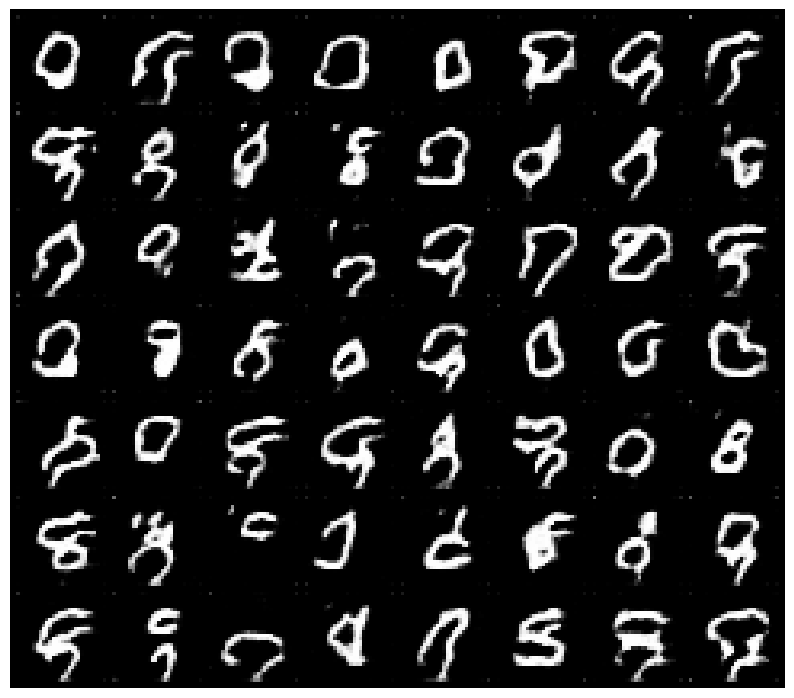

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.22it/s, loss_D=1.03, loss_G=1.35]


Epoch [5/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [5/400] - Average D loss: 1.0581, Average G loss: 1.1531


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=1.06, loss_G=1.47]


Epoch [6/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [6/400] - Average D loss: 1.0634, Average G loss: 1.1641


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.88it/s, loss_D=0.94, loss_G=1.08]


Epoch [7/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [7/400] - Average D loss: 1.0682, Average G loss: 1.1156


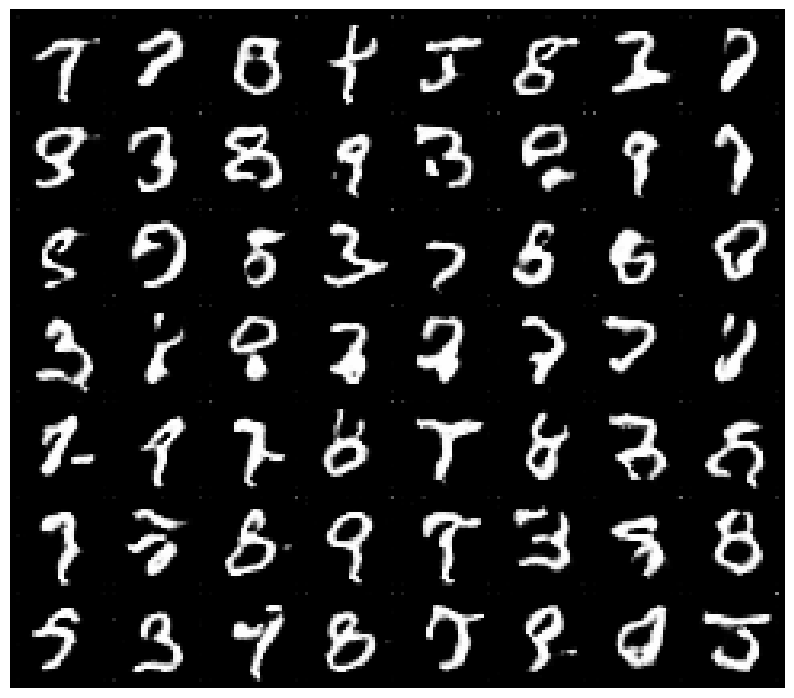

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=1.05, loss_G=1.09]


Epoch [8/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [8/400] - Average D loss: 1.0464, Average G loss: 1.1271


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.931, loss_G=1.13]


Epoch [9/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [9/400] - Average D loss: 1.0271, Average G loss: 1.1549


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.941, loss_G=1.25]


Epoch [10/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [10/400] - Average D loss: 0.9873, Average G loss: 1.2248


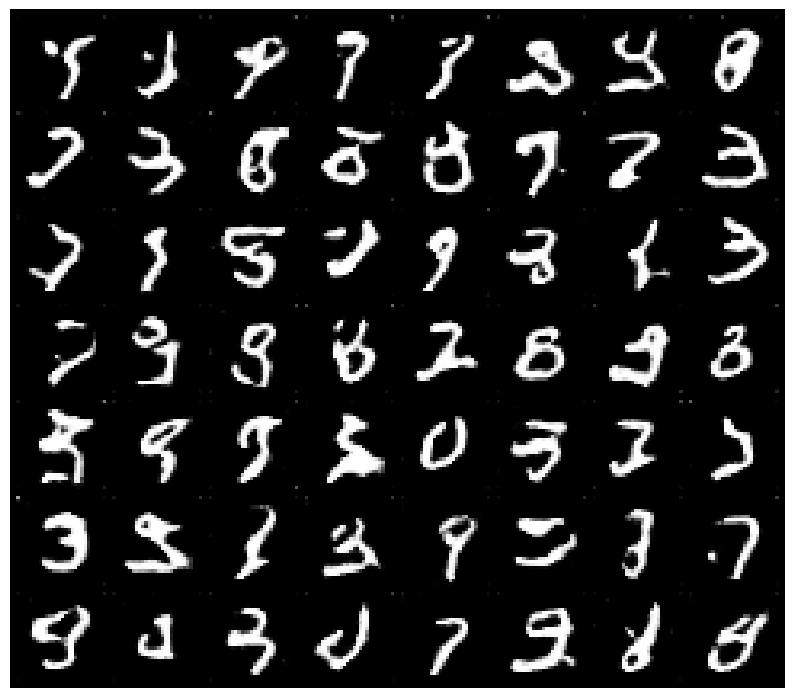

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.997, loss_G=1.87]


Epoch [11/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [11/400] - Average D loss: 0.9437, Average G loss: 1.3074


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=1.11, loss_G=1.67]


Epoch [12/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [12/400] - Average D loss: 0.9150, Average G loss: 1.3723


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.775, loss_G=1.32]


Epoch [13/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [13/400] - Average D loss: 0.8827, Average G loss: 1.4461


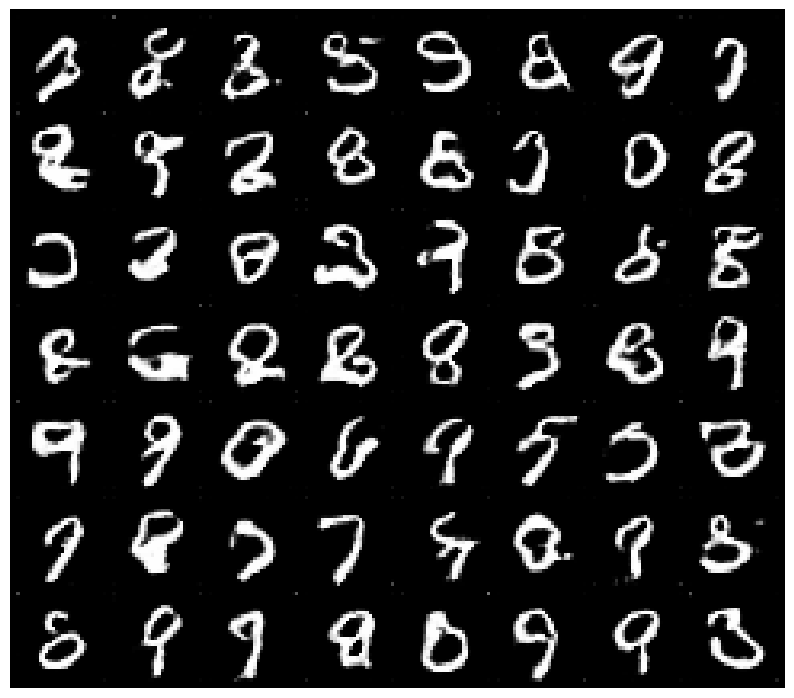

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.88it/s, loss_D=0.989, loss_G=1.52]


Epoch [14/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [14/400] - Average D loss: 0.8565, Average G loss: 1.5067


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.726, loss_G=1.64]


Epoch [15/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [15/400] - Average D loss: 0.8308, Average G loss: 1.5645


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.809, loss_G=1.84]


Epoch [16/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [16/400] - Average D loss: 0.8109, Average G loss: 1.6178


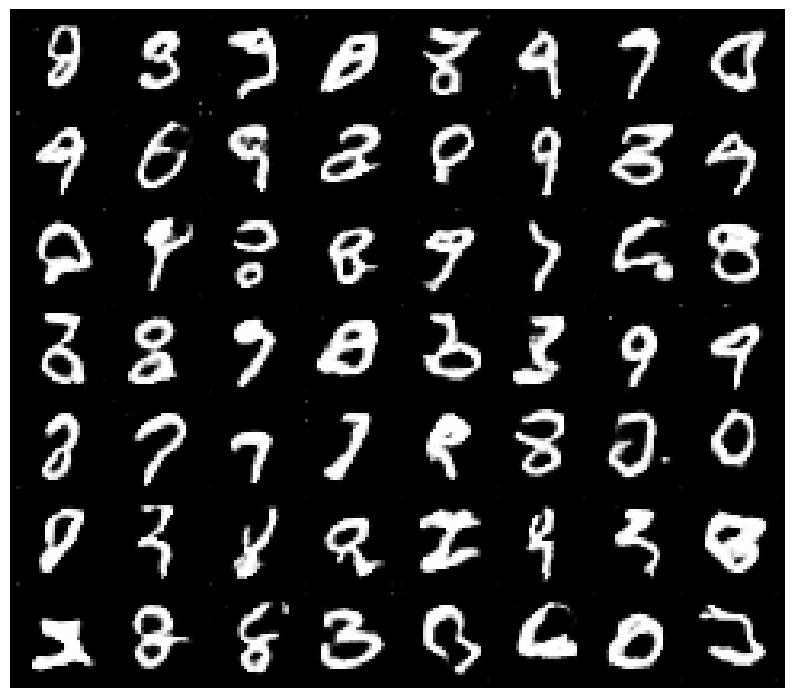

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=0.739, loss_G=1.86]


Epoch [17/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [17/400] - Average D loss: 0.7934, Average G loss: 1.6734


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.794, loss_G=2.02]


Epoch [18/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [18/400] - Average D loss: 0.7731, Average G loss: 1.7176


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.769, loss_G=1.98]


Epoch [19/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [19/400] - Average D loss: 0.7673, Average G loss: 1.7394


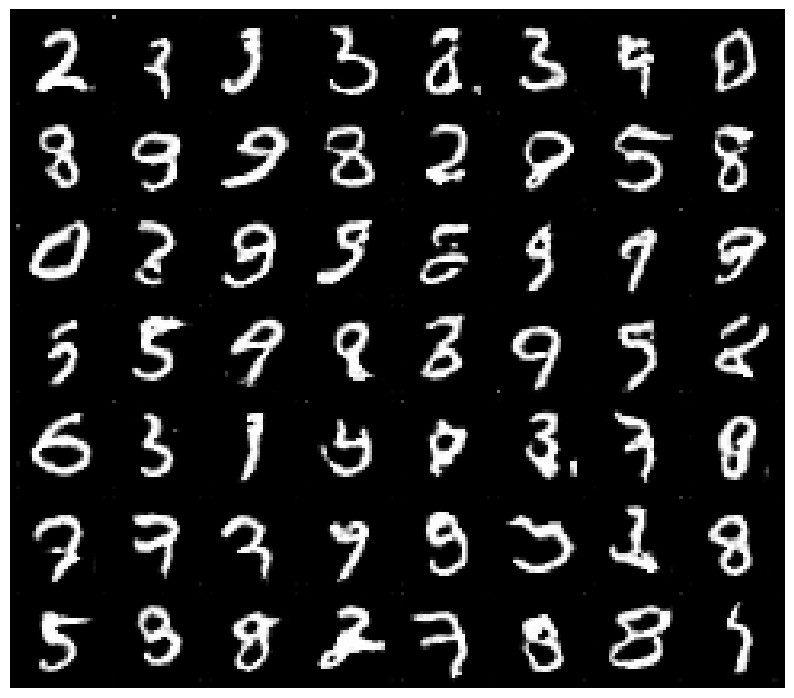

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.19it/s, loss_D=0.888, loss_G=1.72]


Epoch [20/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [20/400] - Average D loss: 0.7527, Average G loss: 1.7823


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.721, loss_G=1.59]


Epoch [21/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [21/400] - Average D loss: 0.7348, Average G loss: 1.8087


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.691, loss_G=1.6]


Epoch [22/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [22/400] - Average D loss: 0.7260, Average G loss: 1.8133


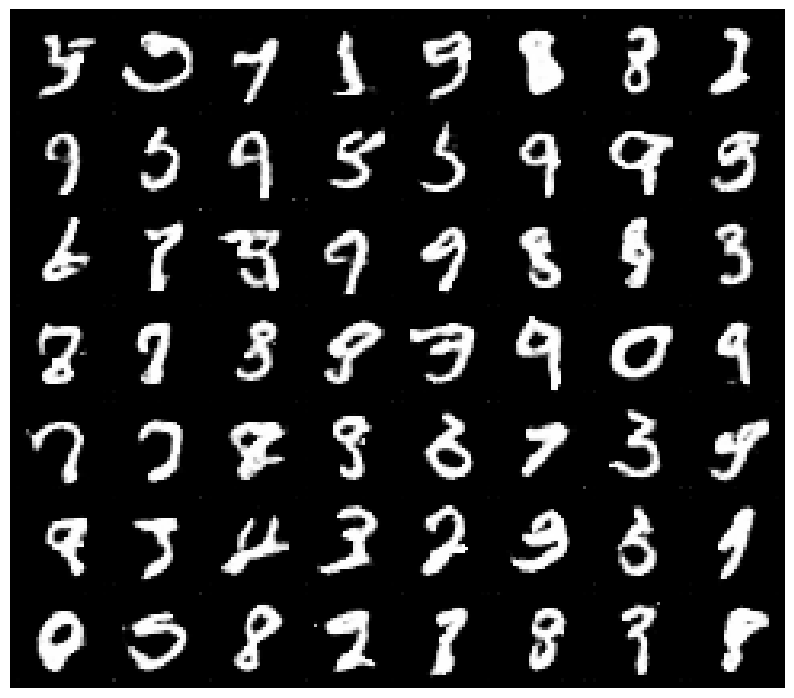

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.665, loss_G=2.08]


Epoch [23/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [23/400] - Average D loss: 0.7143, Average G loss: 1.8556


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.575, loss_G=2.07]


Epoch [24/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [24/400] - Average D loss: 0.7208, Average G loss: 1.8599


100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.674, loss_G=2]


Epoch [25/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [25/400] - Average D loss: 0.7130, Average G loss: 1.8734


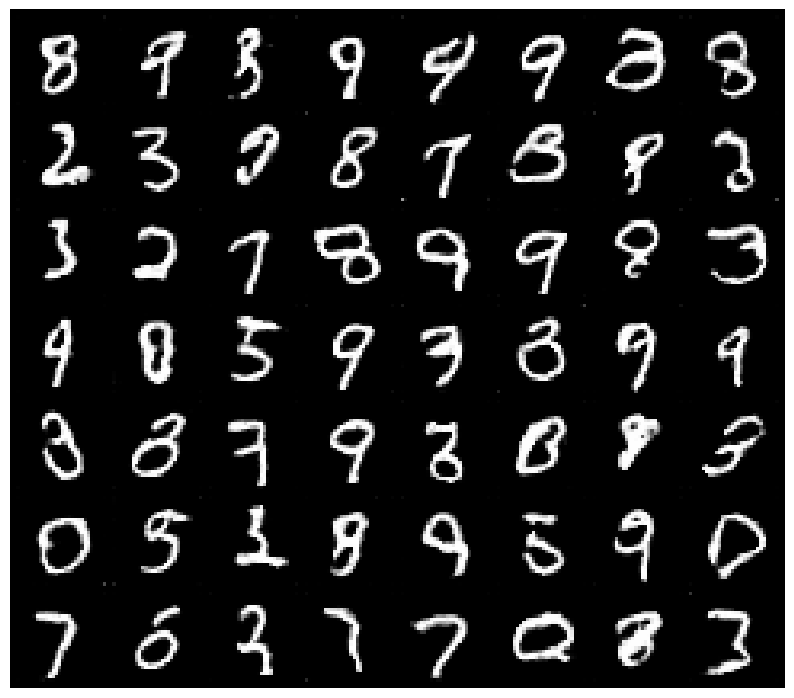

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.625, loss_G=2.03]


Epoch [26/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [26/400] - Average D loss: 0.7100, Average G loss: 1.8876


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.633, loss_G=1.64]


Epoch [27/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [27/400] - Average D loss: 0.7123, Average G loss: 1.8812


100%|███████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.8, loss_G=1.32]


Epoch [28/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [28/400] - Average D loss: 0.7099, Average G loss: 1.8860


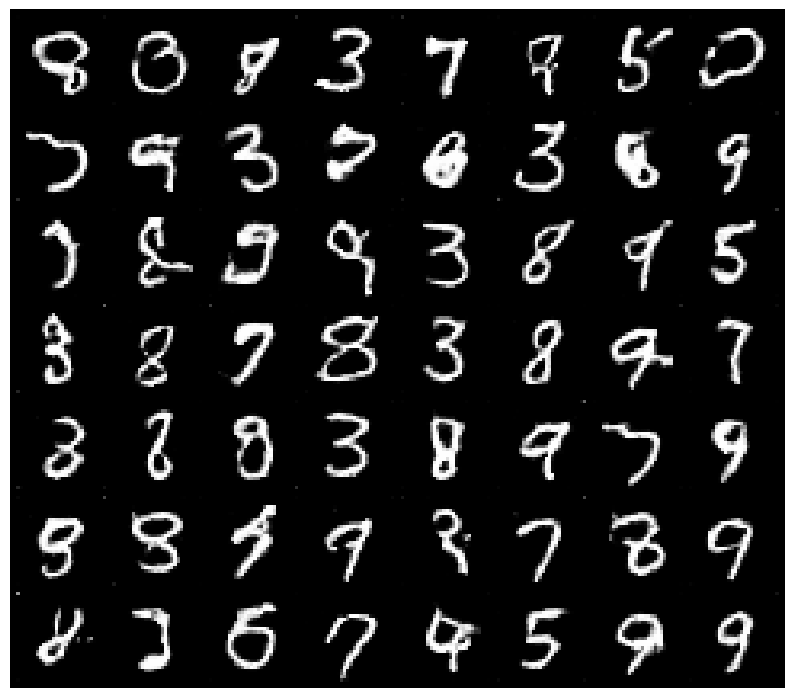

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.651, loss_G=1.74]


Epoch [29/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [29/400] - Average D loss: 0.7111, Average G loss: 1.8807


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.61, loss_G=2.29]


Epoch [30/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [30/400] - Average D loss: 0.7064, Average G loss: 1.8880


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.81it/s, loss_D=0.482, loss_G=2.4]


Epoch [31/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [31/400] - Average D loss: 0.7030, Average G loss: 1.9001


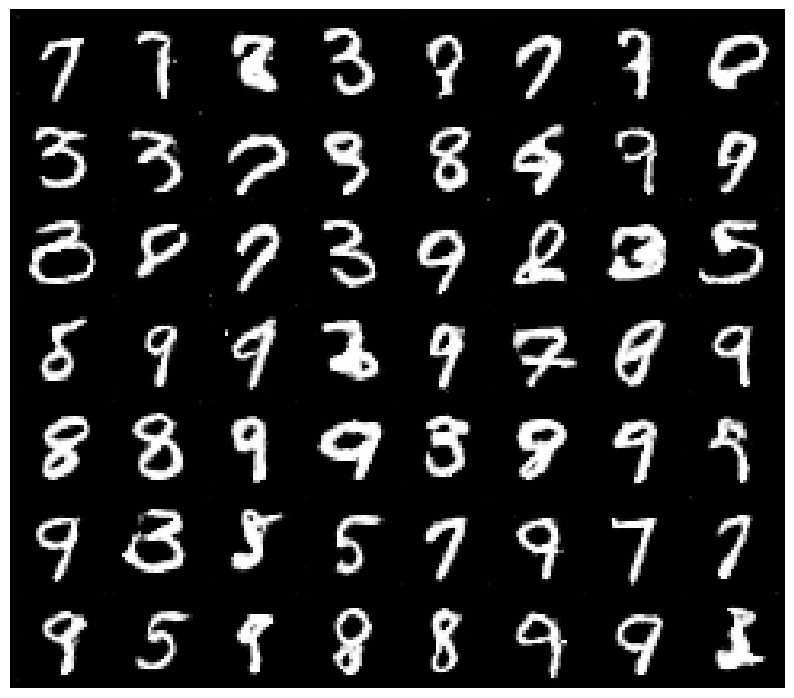

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.693, loss_G=1.55]


Epoch [32/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [32/400] - Average D loss: 0.7040, Average G loss: 1.8853


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.634, loss_G=1.87]


Epoch [33/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [33/400] - Average D loss: 0.7028, Average G loss: 1.8979


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=0.724, loss_G=1.86]


Epoch [34/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [34/400] - Average D loss: 0.6996, Average G loss: 1.9038


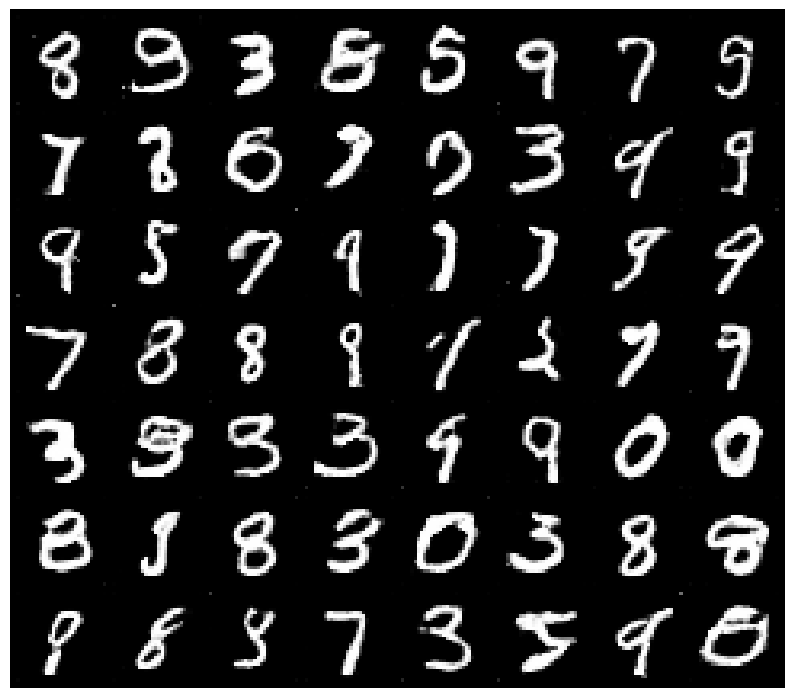

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.76it/s, loss_D=0.598, loss_G=2.17]


Epoch [35/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [35/400] - Average D loss: 0.7065, Average G loss: 1.8857


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.776, loss_G=1.75]


Epoch [36/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [36/400] - Average D loss: 0.7078, Average G loss: 1.8675


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.678, loss_G=1.8]


Epoch [37/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [37/400] - Average D loss: 0.7040, Average G loss: 1.8849


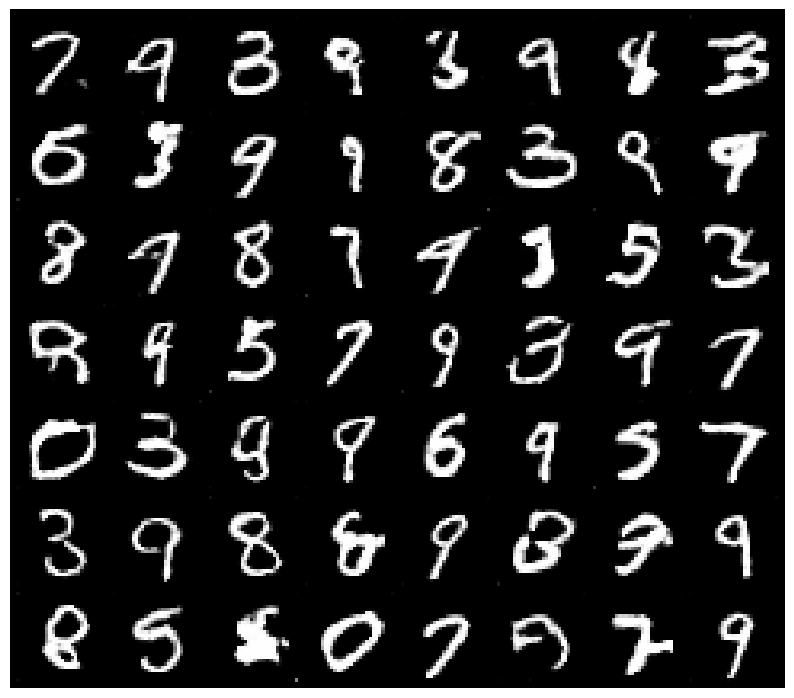

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.64it/s, loss_D=0.73, loss_G=2.28]


Epoch [38/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [38/400] - Average D loss: 0.7081, Average G loss: 1.8776


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.642, loss_G=2.07]


Epoch [39/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [39/400] - Average D loss: 0.7079, Average G loss: 1.8676


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.67, loss_G=1.84]


Epoch [40/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [40/400] - Average D loss: 0.7056, Average G loss: 1.8562


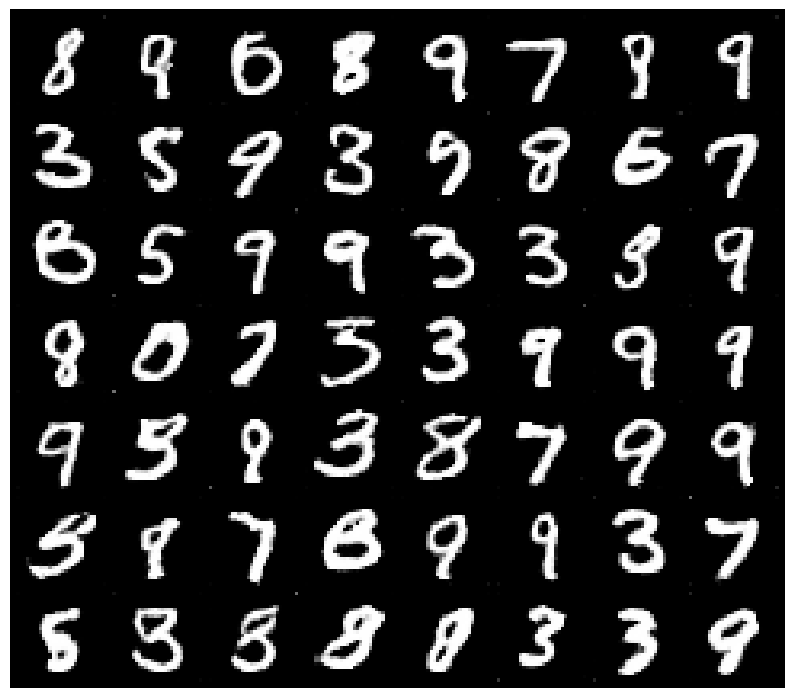

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.674, loss_G=1.75]


Epoch [41/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [41/400] - Average D loss: 0.7031, Average G loss: 1.8566


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.773, loss_G=1.75]


Epoch [42/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [42/400] - Average D loss: 0.7044, Average G loss: 1.8576


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.799, loss_G=1.61]


Epoch [43/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [43/400] - Average D loss: 0.7011, Average G loss: 1.8647


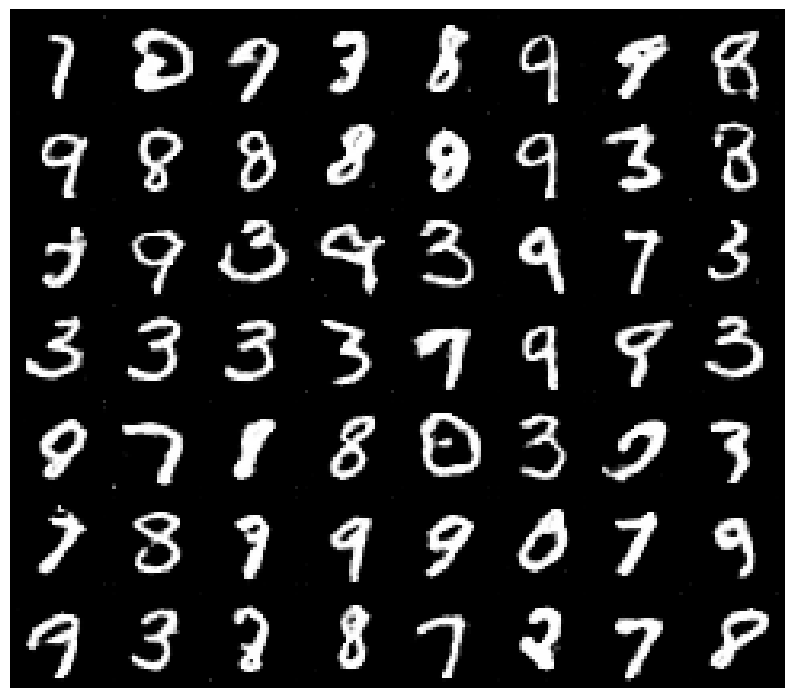

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.622, loss_G=1.86]


Epoch [44/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [44/400] - Average D loss: 0.7020, Average G loss: 1.8604


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.596, loss_G=1.74]


Epoch [45/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [45/400] - Average D loss: 0.7008, Average G loss: 1.8640


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=0.603, loss_G=1.82]


Epoch [46/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [46/400] - Average D loss: 0.7016, Average G loss: 1.8689


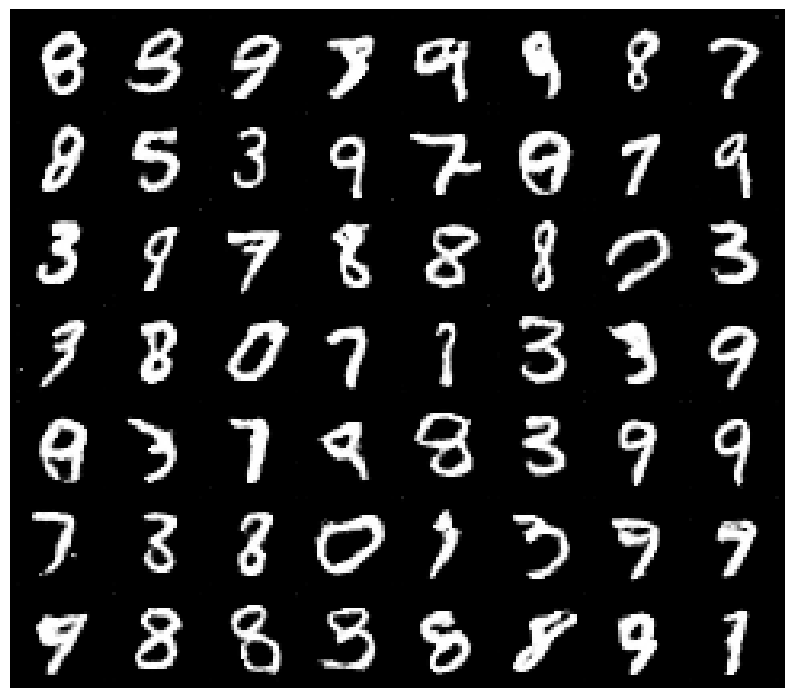

100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.828, loss_G=2]


Epoch [47/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [47/400] - Average D loss: 0.7015, Average G loss: 1.8595


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.725, loss_G=1.73]


Epoch [48/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [48/400] - Average D loss: 0.7024, Average G loss: 1.8655


100%|█████████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.19it/s, loss_D=0.76, loss_G=2]


Epoch [49/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [49/400] - Average D loss: 0.7008, Average G loss: 1.8510


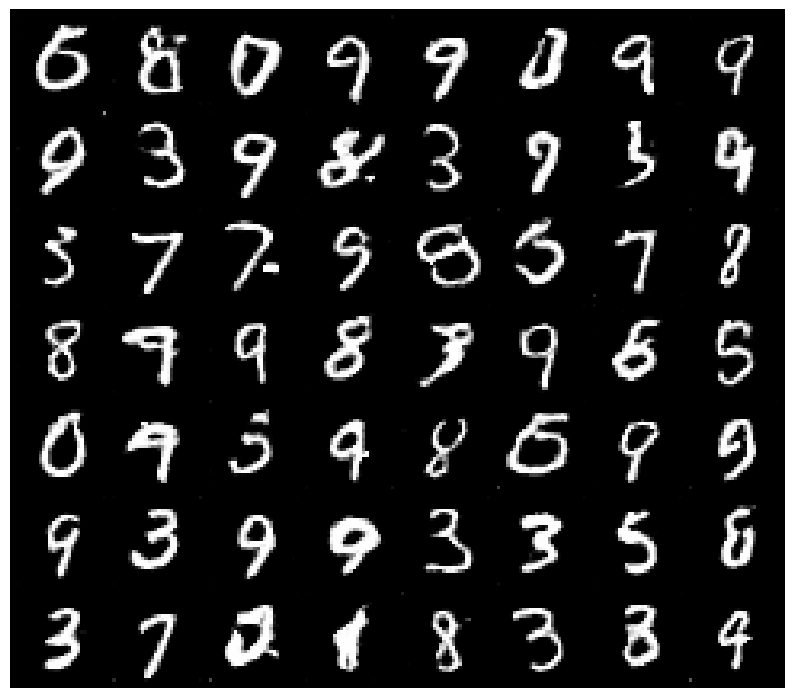

100%|█████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.17it/s, loss_D=0.748, loss_G=1.86]


Epoch [50/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/400] - Average D loss: 0.6987, Average G loss: 1.8667


100%|█████████████████████████████████████████████████████| 732/732 [01:08<00:00, 10.66it/s, loss_D=0.724, loss_G=1.82]


Epoch [51/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/400] - Average D loss: 0.7070, Average G loss: 1.8549


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.47, loss_G=2.4]


Epoch [52/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/400] - Average D loss: 0.7012, Average G loss: 1.8601


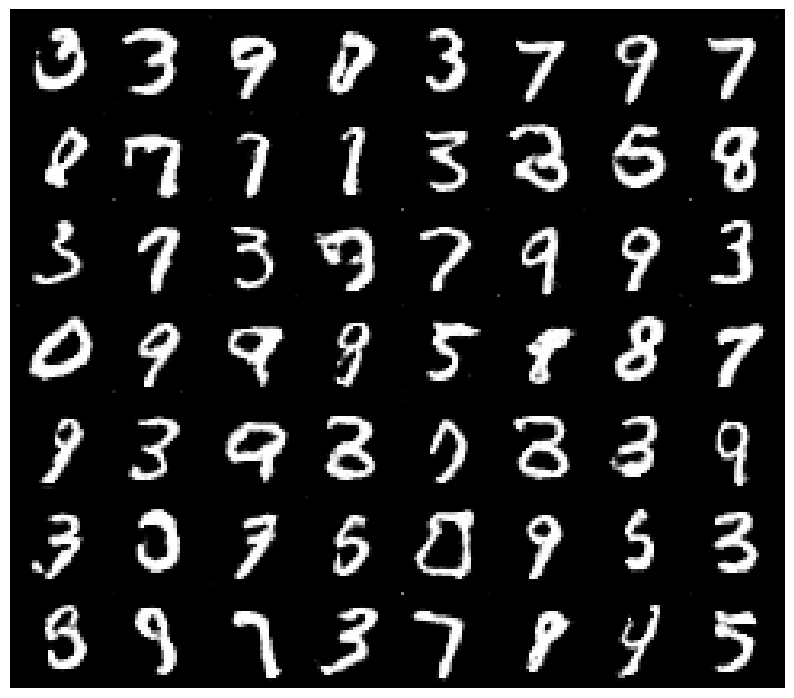

100%|███████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.8, loss_G=1.92]


Epoch [53/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/400] - Average D loss: 0.7026, Average G loss: 1.8534


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.632, loss_G=1.91]


Epoch [54/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/400] - Average D loss: 0.7050, Average G loss: 1.8552


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.811, loss_G=1.54]


Epoch [55/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/400] - Average D loss: 0.7026, Average G loss: 1.8582


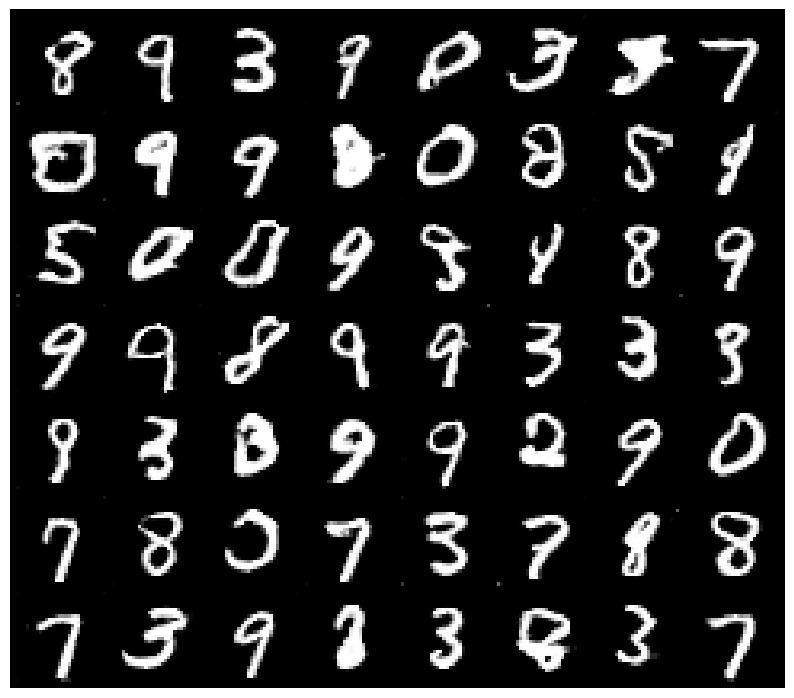

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.584, loss_G=1.97]


Epoch [56/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/400] - Average D loss: 0.7005, Average G loss: 1.8621


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.704, loss_G=1.78]


Epoch [57/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/400] - Average D loss: 0.6995, Average G loss: 1.8654


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.822, loss_G=1.65]


Epoch [58/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/400] - Average D loss: 0.7048, Average G loss: 1.8590


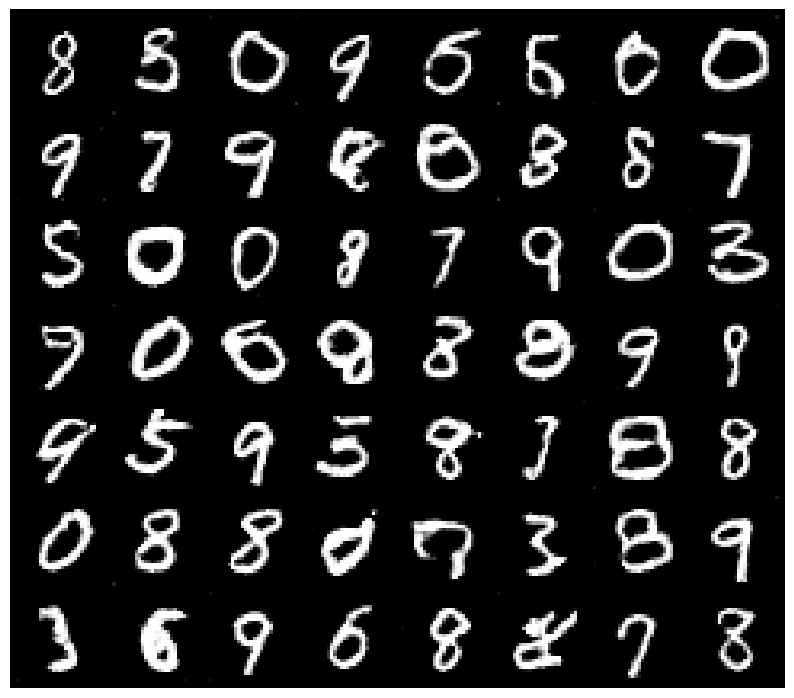

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.813, loss_G=1.58]


Epoch [59/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/400] - Average D loss: 0.7002, Average G loss: 1.8652


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.69it/s, loss_D=0.751, loss_G=1.76]


Epoch [60/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/400] - Average D loss: 0.7029, Average G loss: 1.8706


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.78, loss_G=1.73]


Epoch [61/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/400] - Average D loss: 0.6977, Average G loss: 1.8468


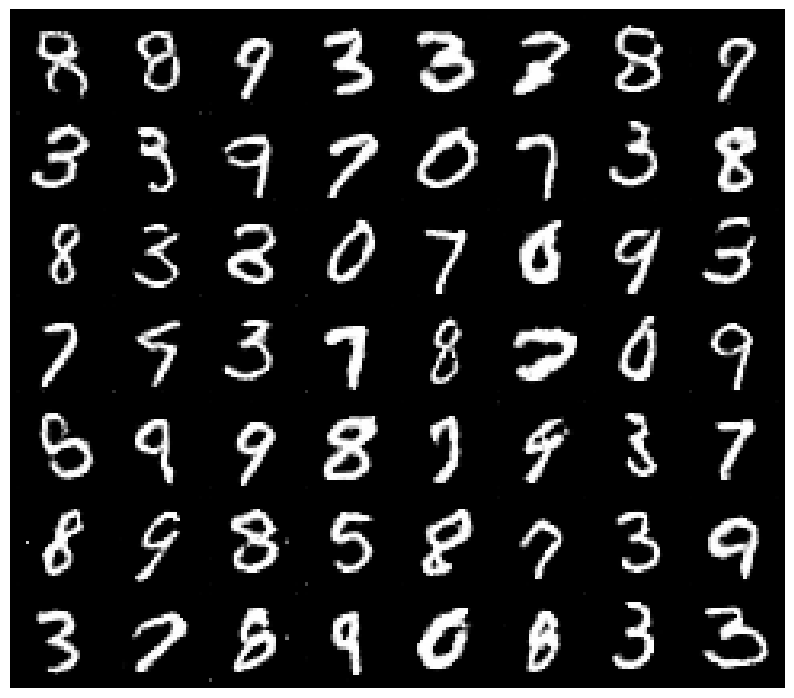

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.63it/s, loss_D=0.793, loss_G=2.02]


Epoch [62/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/400] - Average D loss: 0.6982, Average G loss: 1.8538


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.626, loss_G=2.14]


Epoch [63/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/400] - Average D loss: 0.6974, Average G loss: 1.8604


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.711, loss_G=2.12]


Epoch [64/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/400] - Average D loss: 0.6981, Average G loss: 1.8680


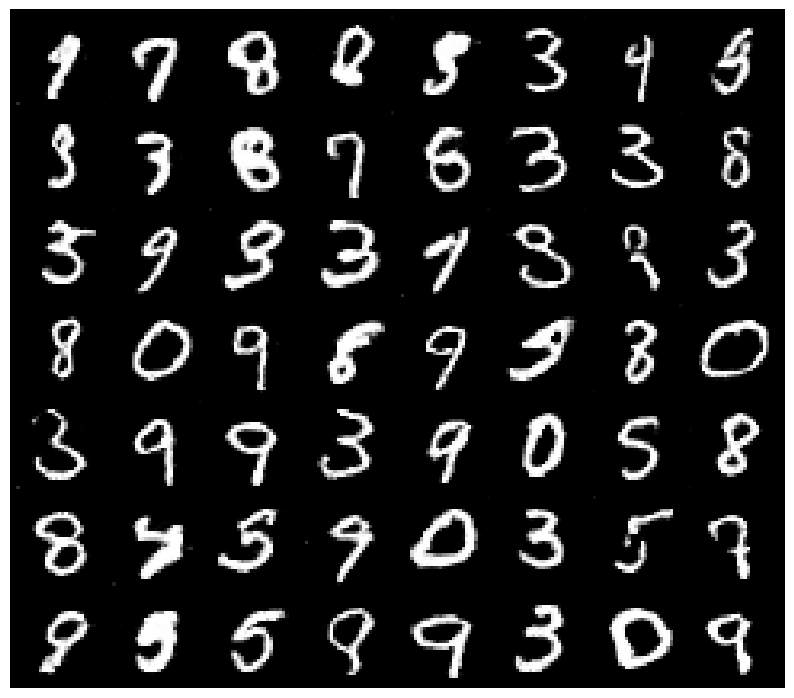

100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.7, loss_G=2.08]


Epoch [65/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/400] - Average D loss: 0.7004, Average G loss: 1.8504


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.557, loss_G=1.91]


Epoch [66/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/400] - Average D loss: 0.6977, Average G loss: 1.8546


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.803, loss_G=1.58]


Epoch [67/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/400] - Average D loss: 0.7024, Average G loss: 1.8505


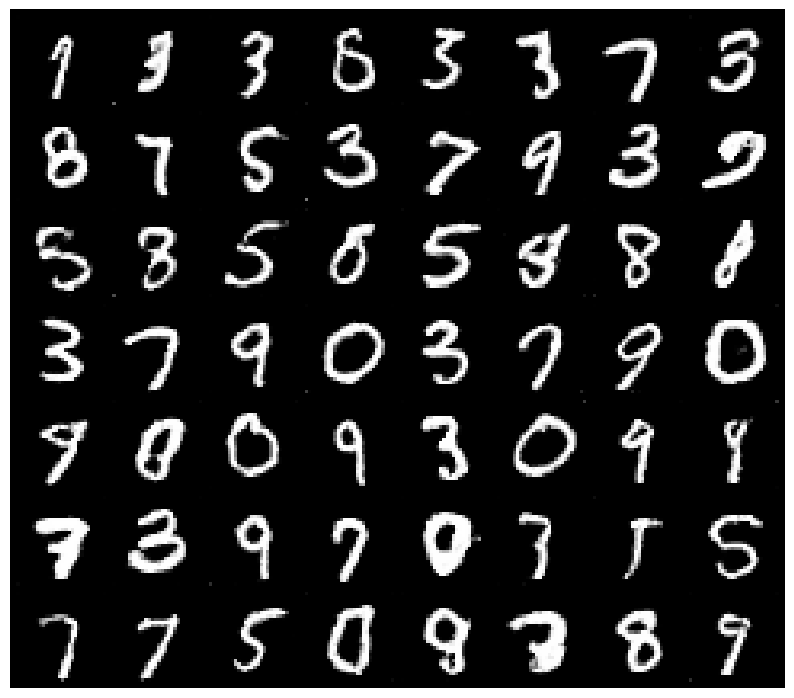

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.81it/s, loss_D=0.716, loss_G=1.84]


Epoch [68/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/400] - Average D loss: 0.7011, Average G loss: 1.8461


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.695, loss_G=1.6]


Epoch [69/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/400] - Average D loss: 0.6951, Average G loss: 1.8435


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.58it/s, loss_D=0.535, loss_G=1.95]


Epoch [70/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [70/400] - Average D loss: 0.6952, Average G loss: 1.8471


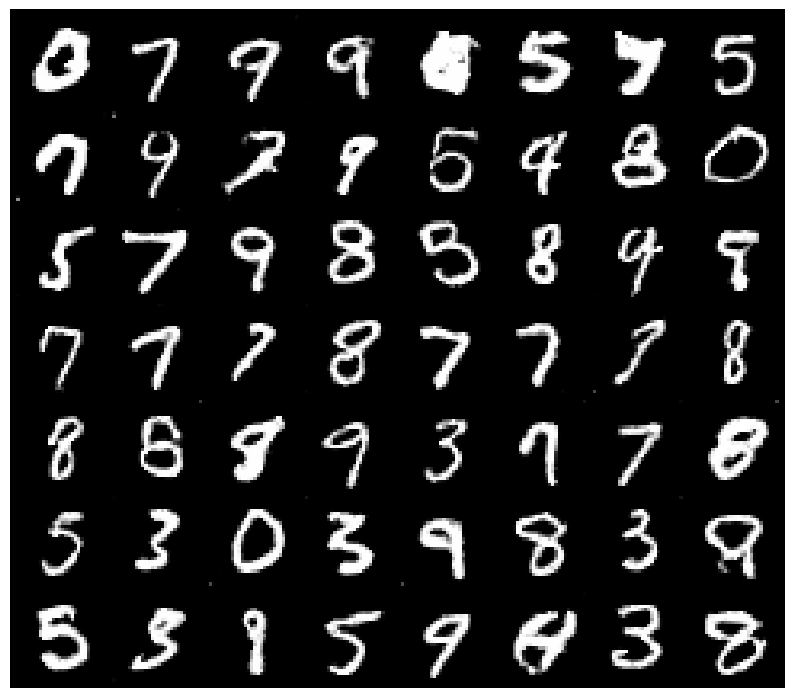

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.70it/s, loss_D=0.708, loss_G=1.99]


Epoch [71/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [71/400] - Average D loss: 0.6995, Average G loss: 1.8540


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.653, loss_G=1.63]


Epoch [72/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [72/400] - Average D loss: 0.6960, Average G loss: 1.8518


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.58it/s, loss_D=0.573, loss_G=2.16]


Epoch [73/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [73/400] - Average D loss: 0.6967, Average G loss: 1.8547


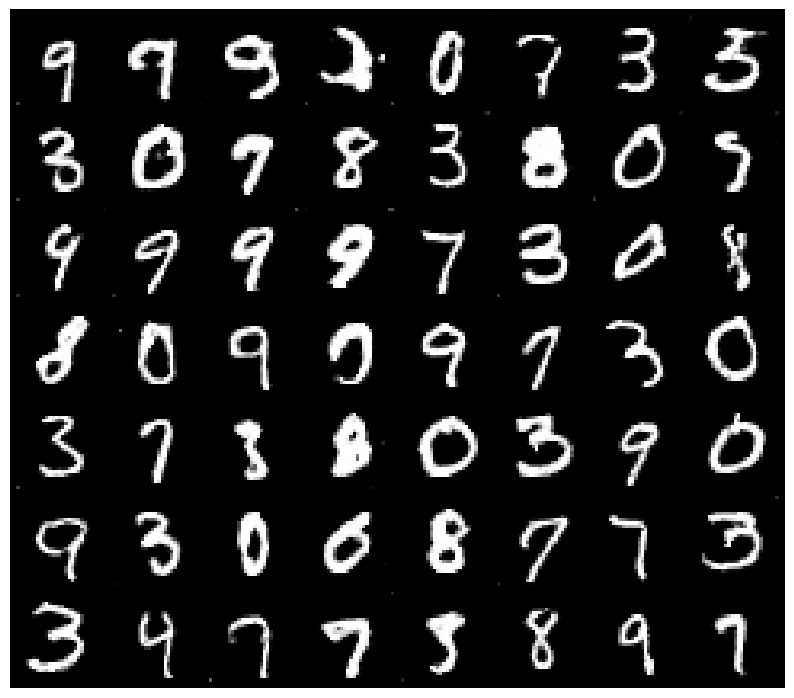

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.752, loss_G=1.5]


Epoch [74/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [74/400] - Average D loss: 0.6956, Average G loss: 1.8571


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.693, loss_G=1.7]


Epoch [75/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [75/400] - Average D loss: 0.6979, Average G loss: 1.8578


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.69it/s, loss_D=0.823, loss_G=1.59]


Epoch [76/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [76/400] - Average D loss: 0.6964, Average G loss: 1.8599


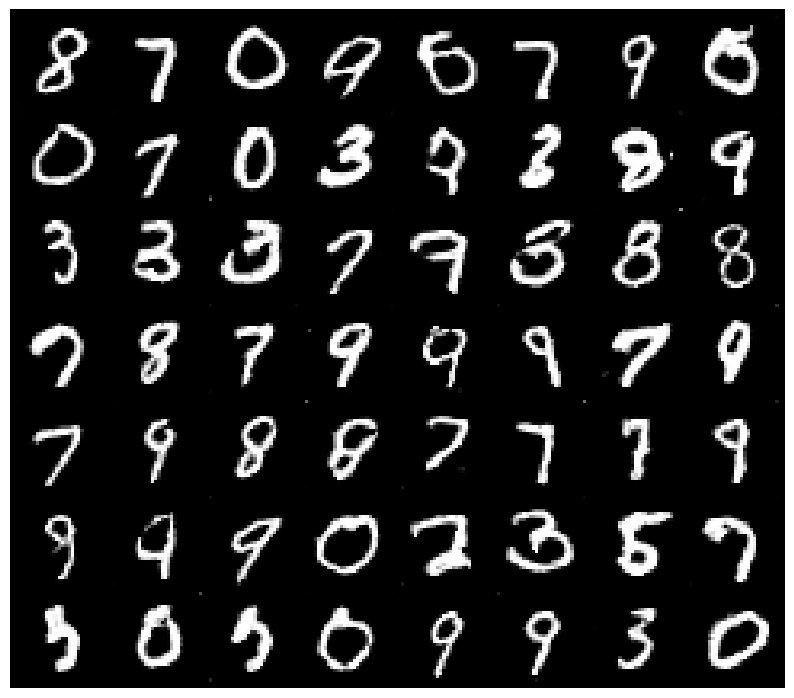

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.59it/s, loss_D=0.802, loss_G=1.62]


Epoch [77/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [77/400] - Average D loss: 0.6996, Average G loss: 1.8466


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.528, loss_G=1.99]


Epoch [78/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [78/400] - Average D loss: 0.6922, Average G loss: 1.8664


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.729, loss_G=1.8]


Epoch [79/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [79/400] - Average D loss: 0.6957, Average G loss: 1.8451


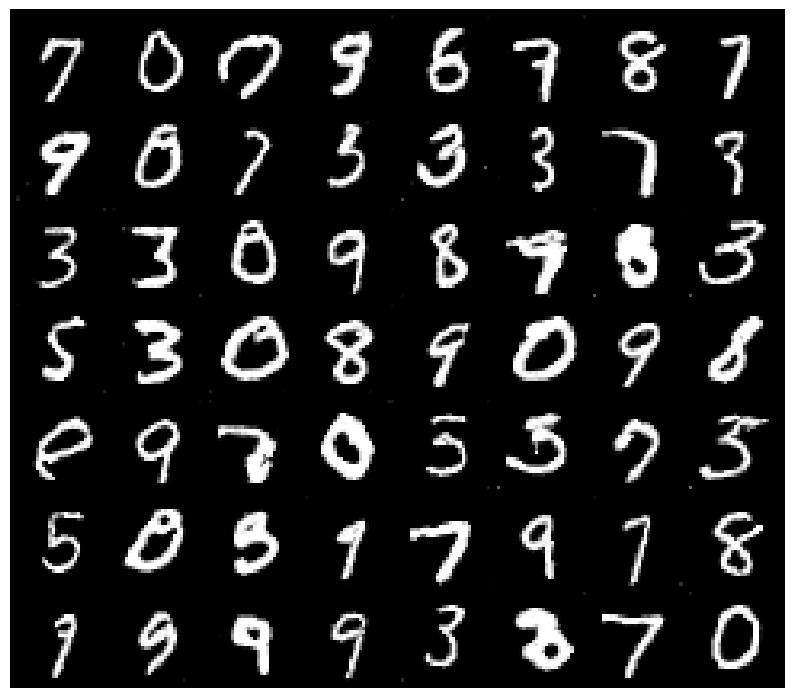

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.81it/s, loss_D=0.643, loss_G=2.08]


Epoch [80/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [80/400] - Average D loss: 0.6942, Average G loss: 1.8692


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.736, loss_G=1.71]


Epoch [81/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [81/400] - Average D loss: 0.6933, Average G loss: 1.8480


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.747, loss_G=2.17]


Epoch [82/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [82/400] - Average D loss: 0.6962, Average G loss: 1.8462


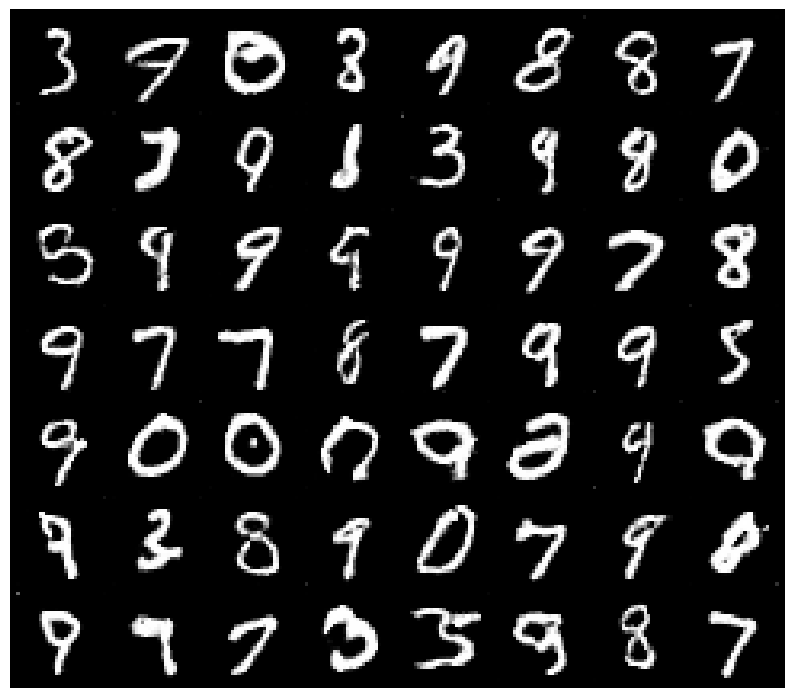

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.705, loss_G=1.94]


Epoch [83/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [83/400] - Average D loss: 0.6909, Average G loss: 1.8438


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.555, loss_G=1.99]


Epoch [84/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [84/400] - Average D loss: 0.6918, Average G loss: 1.8655


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.777, loss_G=1.73]


Epoch [85/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [85/400] - Average D loss: 0.6913, Average G loss: 1.8524


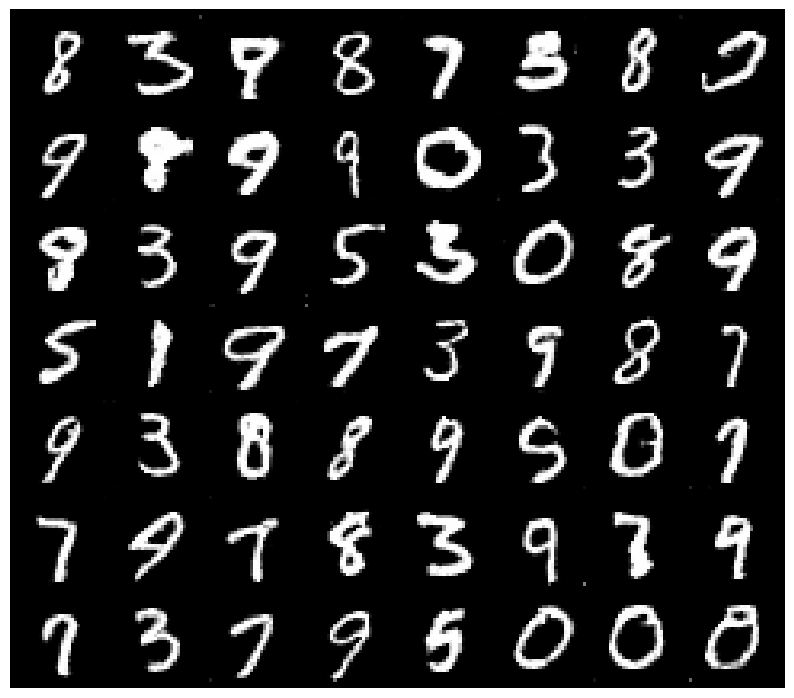

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.824, loss_G=1.96]


Epoch [86/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [86/400] - Average D loss: 0.6907, Average G loss: 1.8606


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.60it/s, loss_D=0.768, loss_G=2.14]


Epoch [87/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [87/400] - Average D loss: 0.6867, Average G loss: 1.8706


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.59it/s, loss_D=0.758, loss_G=2.29]


Epoch [88/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [88/400] - Average D loss: 0.6876, Average G loss: 1.8704


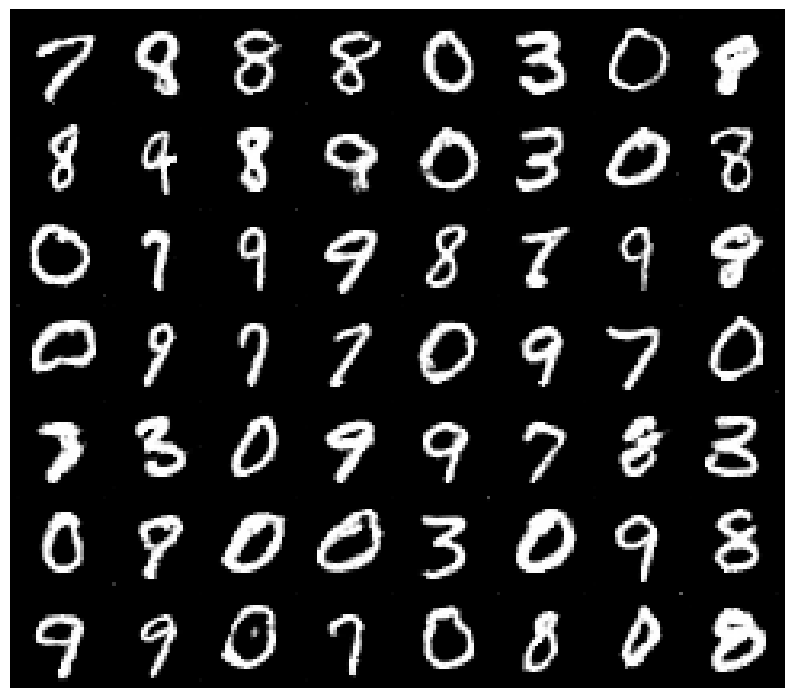

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.56, loss_G=2.27]


Epoch [89/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [89/400] - Average D loss: 0.6893, Average G loss: 1.8558


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.83it/s, loss_D=0.86, loss_G=1.98]


Epoch [90/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [90/400] - Average D loss: 0.6933, Average G loss: 1.8611


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.63, loss_G=1.72]


Epoch [91/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [91/400] - Average D loss: 0.6891, Average G loss: 1.8431


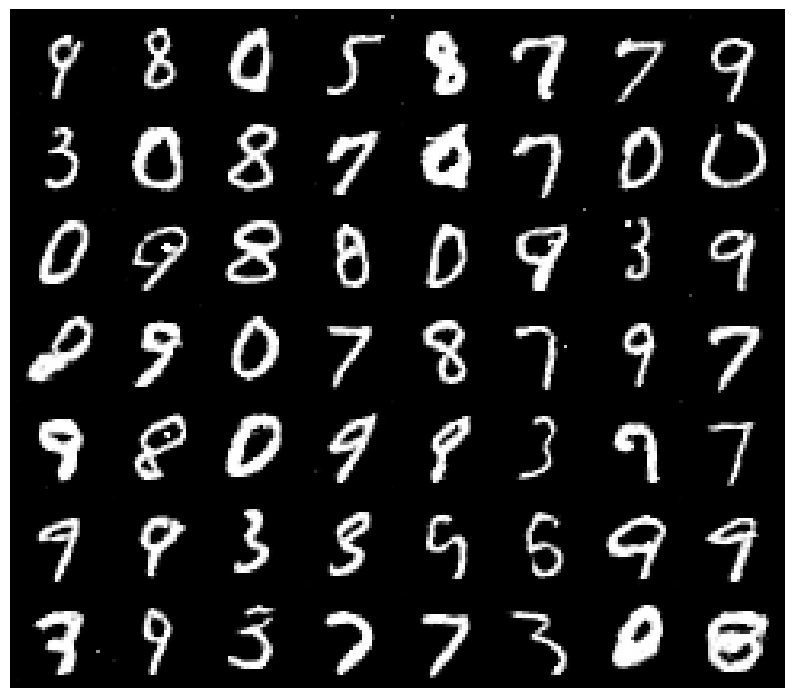

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.746, loss_G=1.87]


Epoch [92/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [92/400] - Average D loss: 0.6852, Average G loss: 1.8756


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.633, loss_G=1.97]


Epoch [93/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [93/400] - Average D loss: 0.6926, Average G loss: 1.8515


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.662, loss_G=1.81]


Epoch [94/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [94/400] - Average D loss: 0.6828, Average G loss: 1.8705


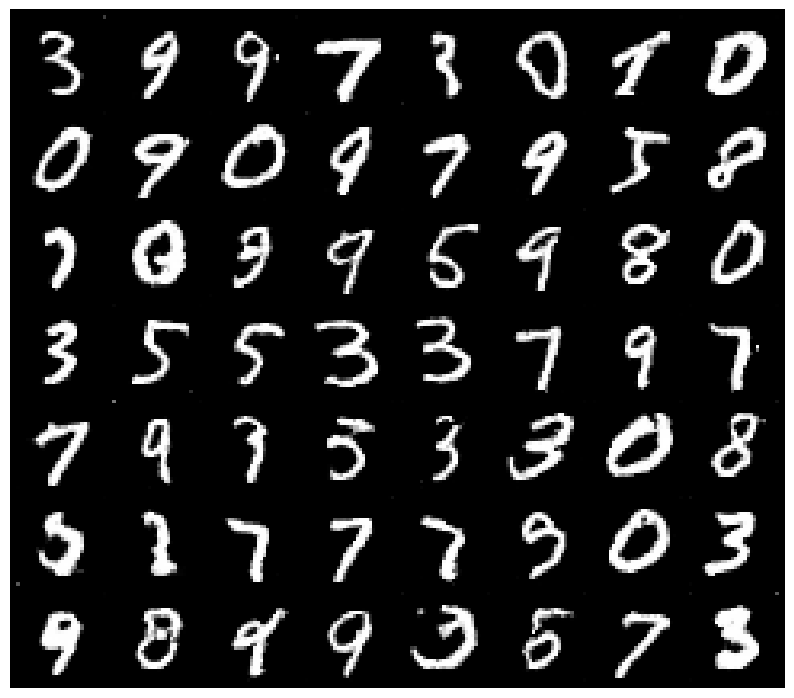

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.644, loss_G=1.96]


Epoch [95/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [95/400] - Average D loss: 0.6848, Average G loss: 1.8675


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.58it/s, loss_D=0.792, loss_G=1.64]


Epoch [96/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [96/400] - Average D loss: 0.6842, Average G loss: 1.8596


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.60it/s, loss_D=0.669, loss_G=1.74]


Epoch [97/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [97/400] - Average D loss: 0.6879, Average G loss: 1.8685


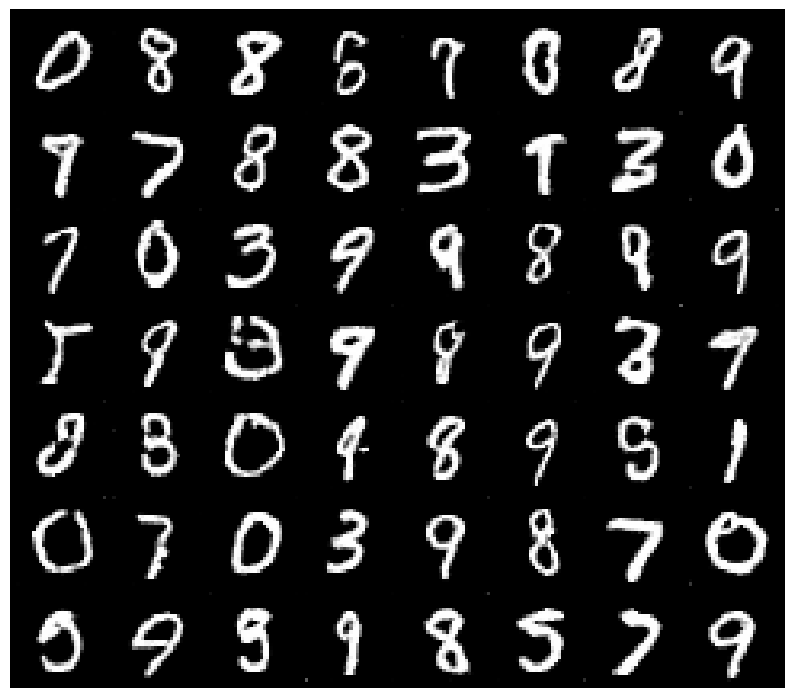

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.86, loss_G=1.65]


Epoch [98/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [98/400] - Average D loss: 0.6846, Average G loss: 1.8705


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.70it/s, loss_D=0.823, loss_G=1.65]


Epoch [99/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [99/400] - Average D loss: 0.6835, Average G loss: 1.8644


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.627, loss_G=1.97]


Epoch [100/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [100/400] - Average D loss: 0.6808, Average G loss: 1.8744


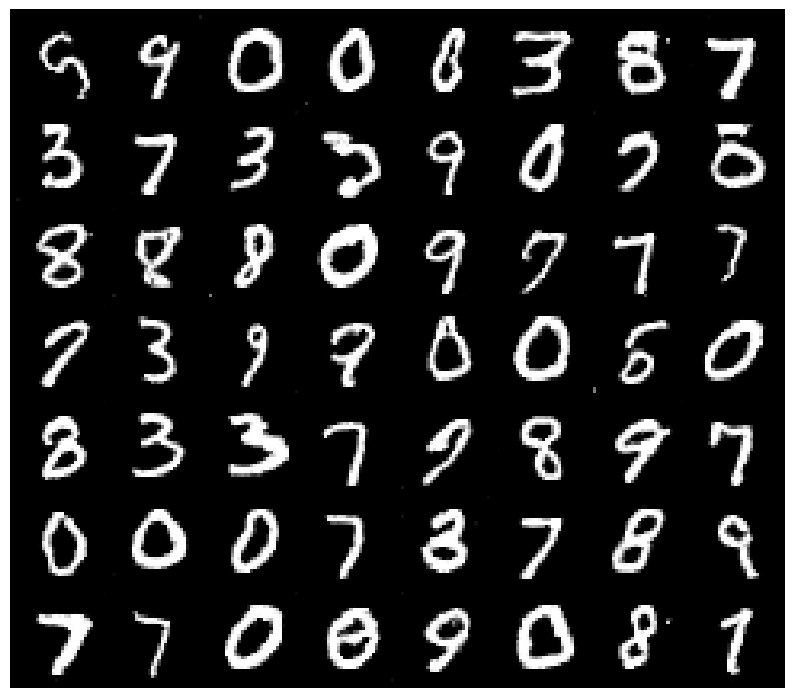

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.671, loss_G=1.85]


Epoch [101/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [101/400] - Average D loss: 0.6781, Average G loss: 1.8622


100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.618, loss_G=2]


Epoch [102/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [102/400] - Average D loss: 0.6788, Average G loss: 1.8703


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.757, loss_G=2.11]


Epoch [103/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [103/400] - Average D loss: 0.6841, Average G loss: 1.8569


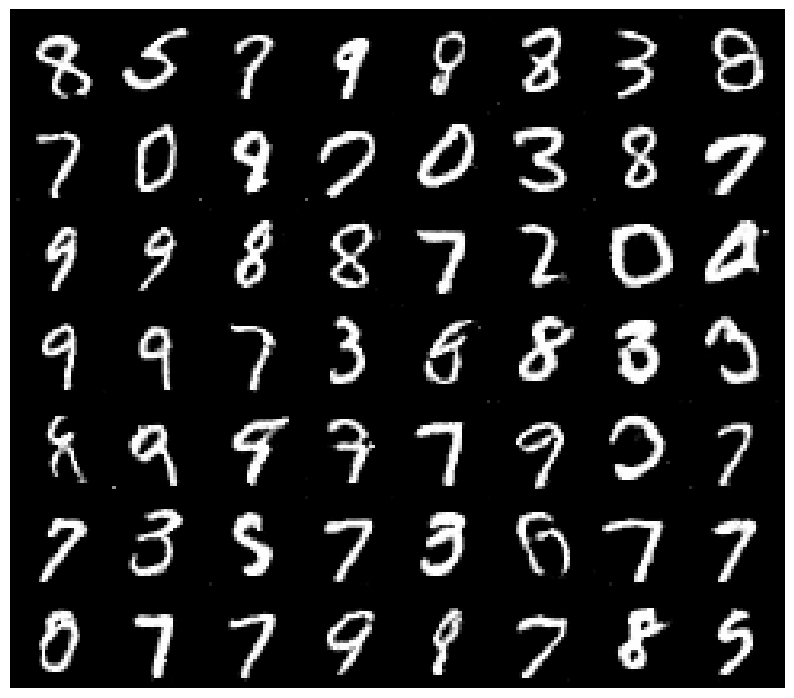

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.537, loss_G=2.01]


Epoch [104/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [104/400] - Average D loss: 0.6768, Average G loss: 1.8736


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.674, loss_G=2.03]


Epoch [105/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [105/400] - Average D loss: 0.6803, Average G loss: 1.8728


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.561, loss_G=1.87]


Epoch [106/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [106/400] - Average D loss: 0.6751, Average G loss: 1.8779


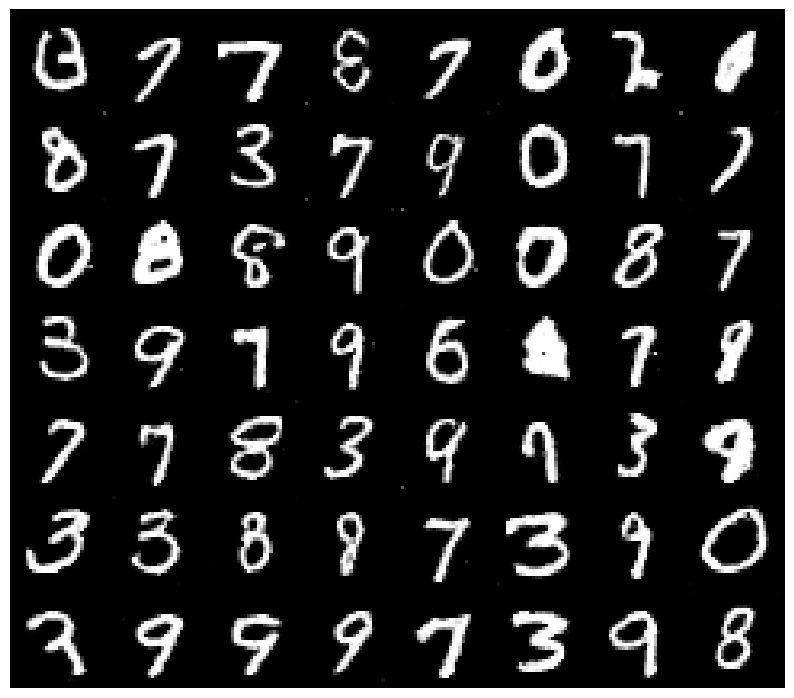

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.63it/s, loss_D=0.773, loss_G=1.9]


Epoch [107/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [107/400] - Average D loss: 0.6757, Average G loss: 1.8829


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.696, loss_G=1.87]


Epoch [108/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [108/400] - Average D loss: 0.6754, Average G loss: 1.8798


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.634, loss_G=1.64]


Epoch [109/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [109/400] - Average D loss: 0.6762, Average G loss: 1.8915


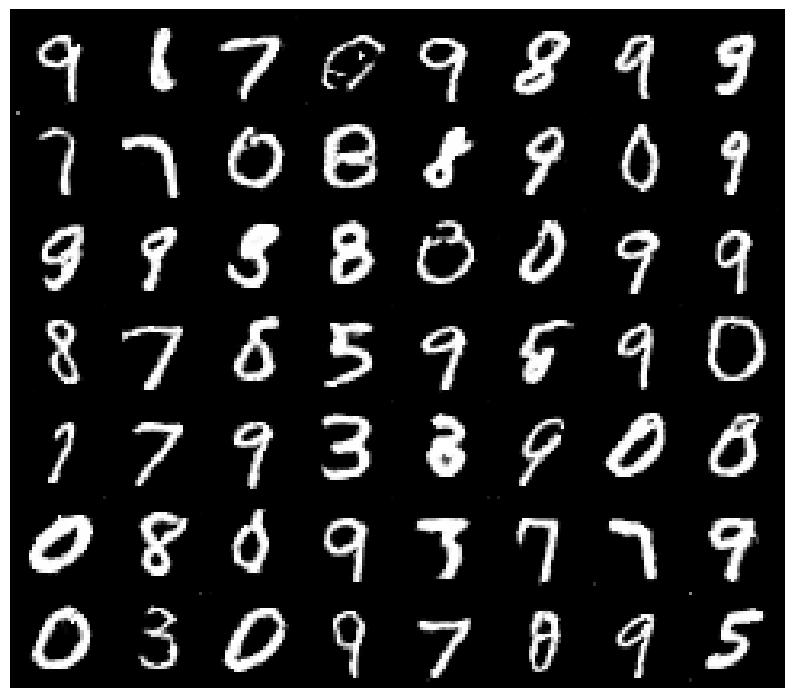

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.56, loss_G=1.71]


Epoch [110/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [110/400] - Average D loss: 0.6713, Average G loss: 1.8826


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.674, loss_G=1.79]


Epoch [111/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [111/400] - Average D loss: 0.6751, Average G loss: 1.8849


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.88it/s, loss_D=0.581, loss_G=1.85]


Epoch [112/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [112/400] - Average D loss: 0.6716, Average G loss: 1.8817


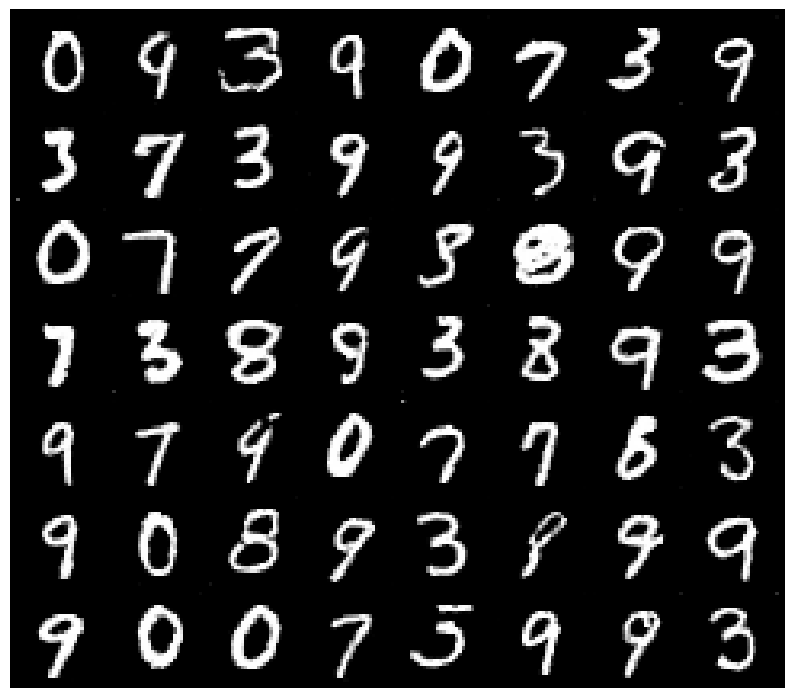

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.657, loss_G=2.21]


Epoch [113/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [113/400] - Average D loss: 0.6750, Average G loss: 1.8768


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.651, loss_G=1.98]


Epoch [114/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [114/400] - Average D loss: 0.6696, Average G loss: 1.8902


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.49it/s, loss_D=0.862, loss_G=1.94]


Epoch [115/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [115/400] - Average D loss: 0.6687, Average G loss: 1.8952


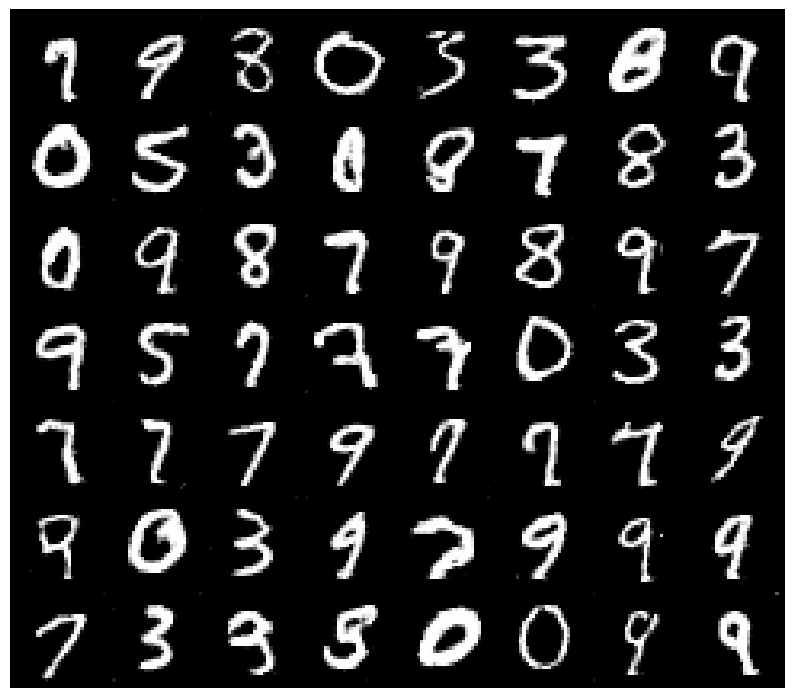

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.18it/s, loss_D=0.614, loss_G=1.92]


Epoch [116/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [116/400] - Average D loss: 0.6703, Average G loss: 1.8864


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.703, loss_G=2.06]


Epoch [117/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [117/400] - Average D loss: 0.6653, Average G loss: 1.9044


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.566, loss_G=1.78]


Epoch [118/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [118/400] - Average D loss: 0.6651, Average G loss: 1.8886


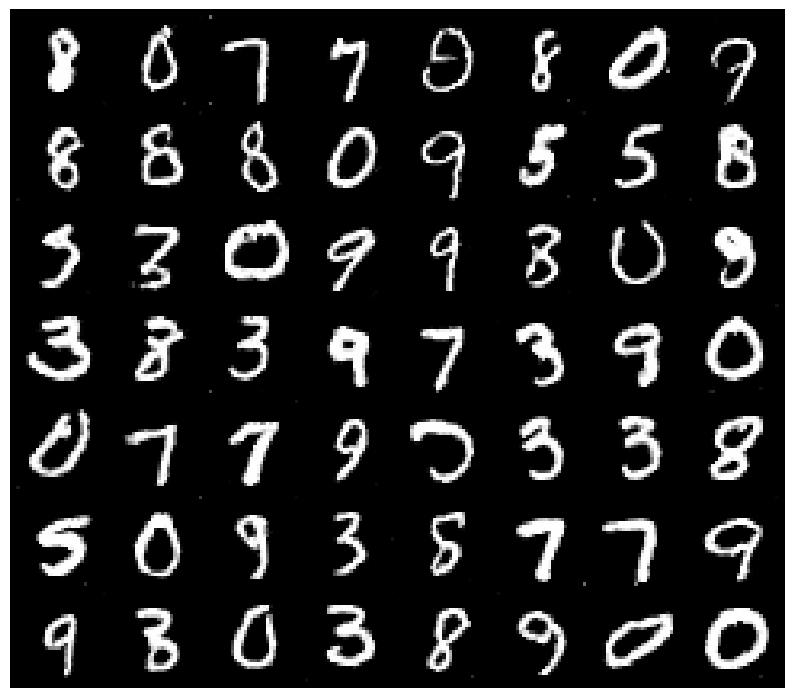

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.65it/s, loss_D=0.538, loss_G=2.22]


Epoch [119/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [119/400] - Average D loss: 0.6673, Average G loss: 1.9000


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.64it/s, loss_D=0.537, loss_G=1.87]


Epoch [120/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [120/400] - Average D loss: 0.6678, Average G loss: 1.8896


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.769, loss_G=2.06]


Epoch [121/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [121/400] - Average D loss: 0.6639, Average G loss: 1.8945


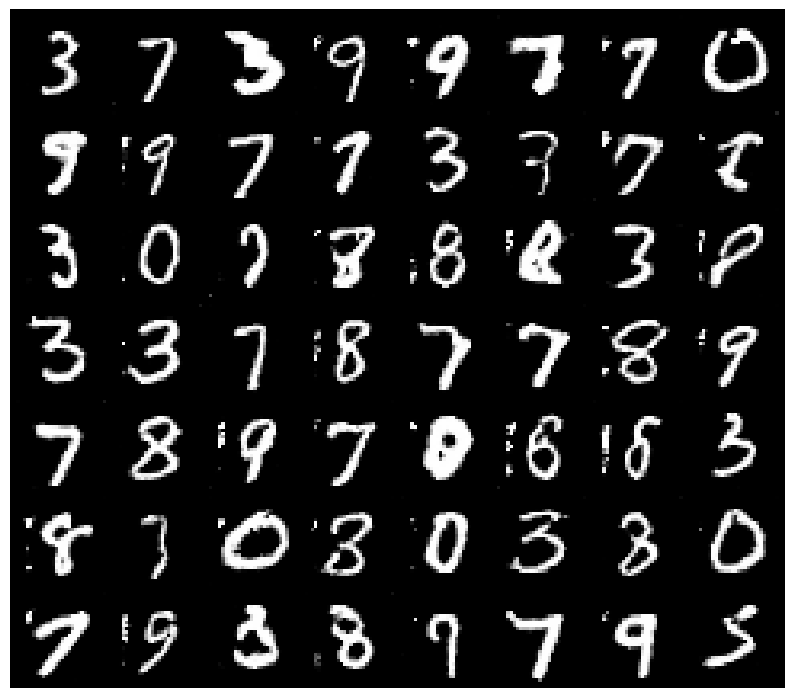

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.486, loss_G=1.92]


Epoch [122/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [122/400] - Average D loss: 0.6771, Average G loss: 1.9050


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.903, loss_G=1.85]


Epoch [123/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [123/400] - Average D loss: 0.6687, Average G loss: 1.8874


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.781, loss_G=1.93]


Epoch [124/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [124/400] - Average D loss: 0.6665, Average G loss: 1.8911


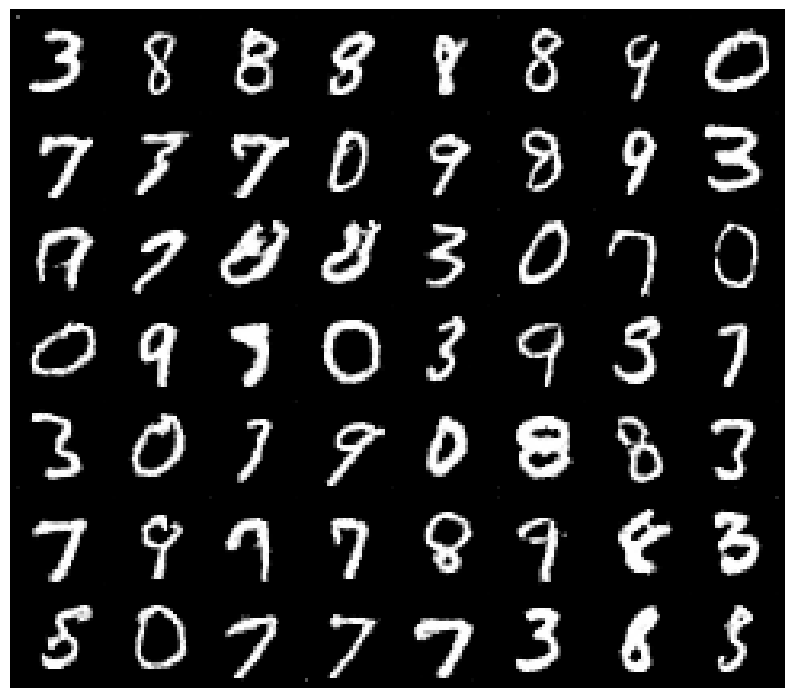

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.768, loss_G=1.86]


Epoch [125/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [125/400] - Average D loss: 0.6654, Average G loss: 1.8999


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.599, loss_G=1.97]


Epoch [126/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [126/400] - Average D loss: 0.6634, Average G loss: 1.9229


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.66, loss_G=1.87]


Epoch [127/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [127/400] - Average D loss: 0.6656, Average G loss: 1.8907


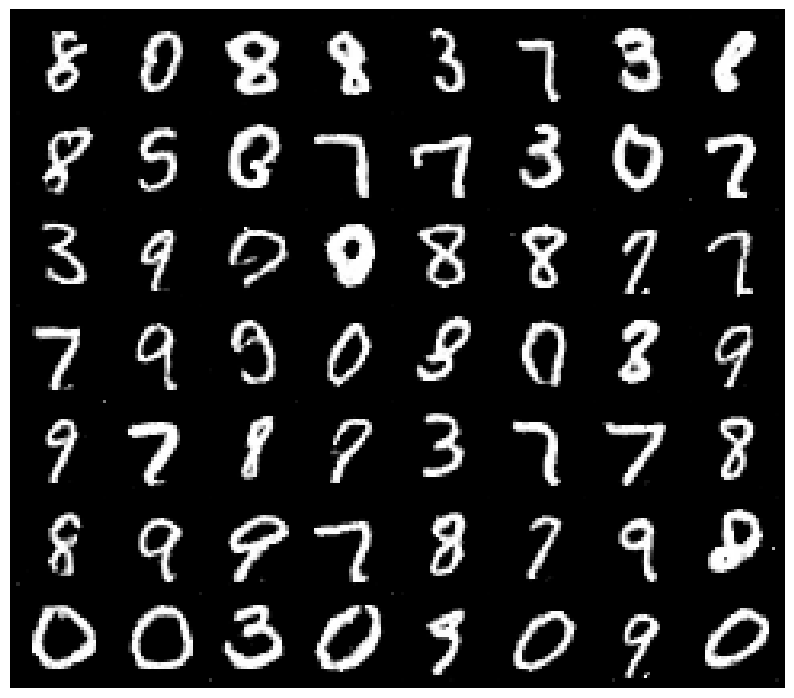

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.60it/s, loss_D=0.709, loss_G=1.5]


Epoch [128/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [128/400] - Average D loss: 0.6614, Average G loss: 1.8968


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.578, loss_G=1.98]


Epoch [129/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [129/400] - Average D loss: 0.6675, Average G loss: 1.8952


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.50it/s, loss_D=0.606, loss_G=2.04]


Epoch [130/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [130/400] - Average D loss: 0.6638, Average G loss: 1.8896


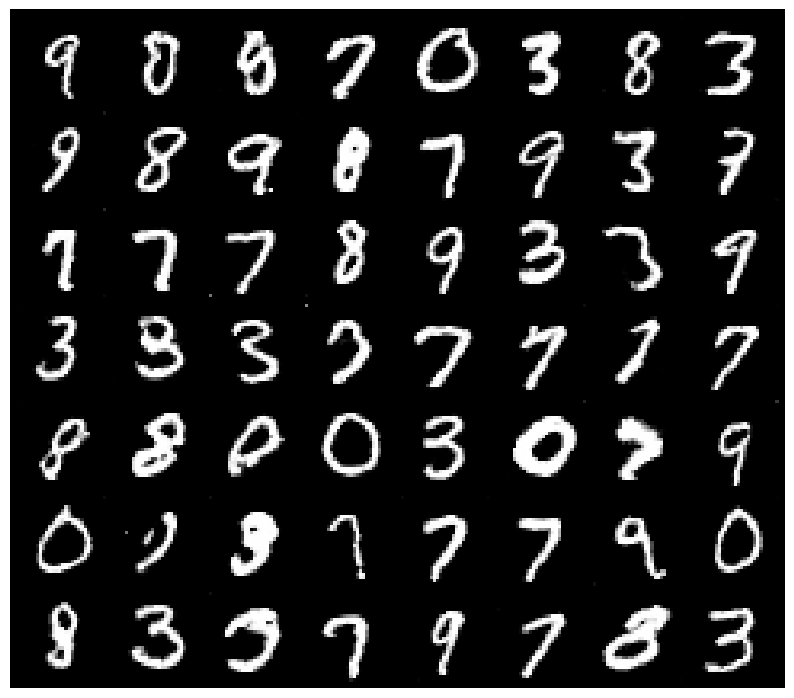

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.556, loss_G=1.97]


Epoch [131/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [131/400] - Average D loss: 0.6639, Average G loss: 1.9041


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.649, loss_G=2.25]


Epoch [132/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [132/400] - Average D loss: 0.6622, Average G loss: 1.8974


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.669, loss_G=1.92]


Epoch [133/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [133/400] - Average D loss: 0.6622, Average G loss: 1.9082


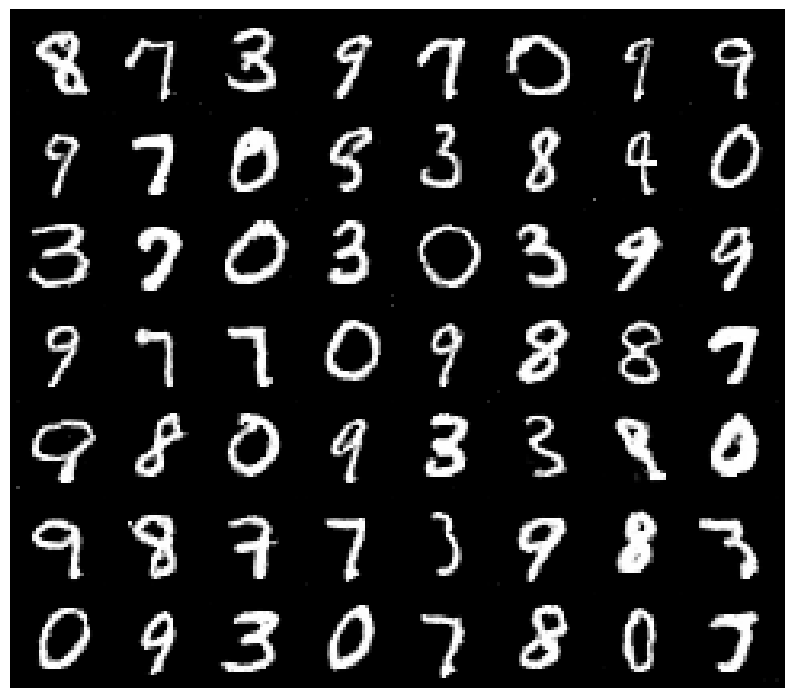

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.679, loss_G=1.91]


Epoch [134/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [134/400] - Average D loss: 0.6602, Average G loss: 1.9138


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.55it/s, loss_D=0.516, loss_G=2.12]


Epoch [135/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [135/400] - Average D loss: 0.6559, Average G loss: 1.9152


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.61it/s, loss_D=0.57, loss_G=2.25]


Epoch [136/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [136/400] - Average D loss: 0.6586, Average G loss: 1.9152


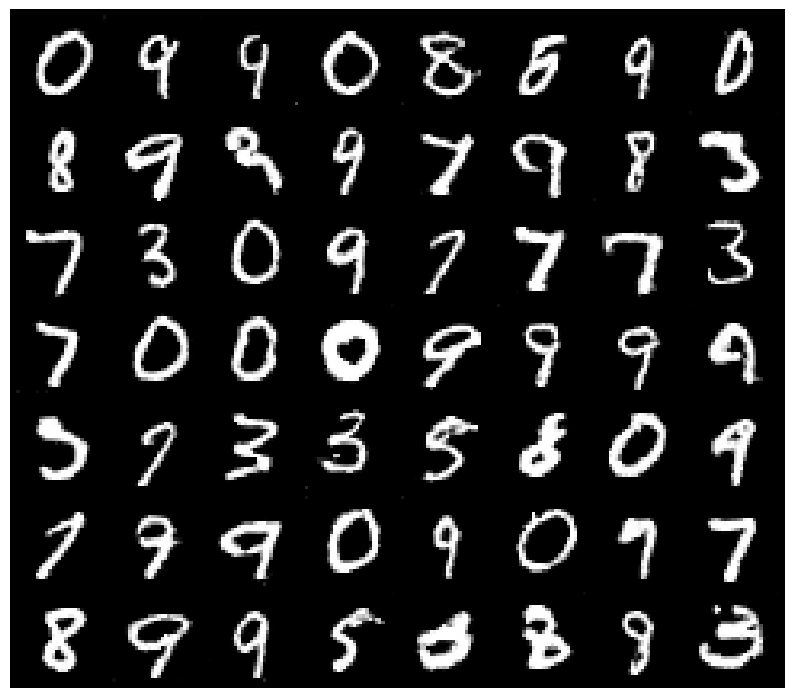

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.615, loss_G=1.84]


Epoch [137/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [137/400] - Average D loss: 0.6649, Average G loss: 1.9172


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.755, loss_G=1.64]


Epoch [138/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [138/400] - Average D loss: 0.6568, Average G loss: 1.9067


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.681, loss_G=2.03]


Epoch [139/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [139/400] - Average D loss: 0.6504, Average G loss: 1.9298


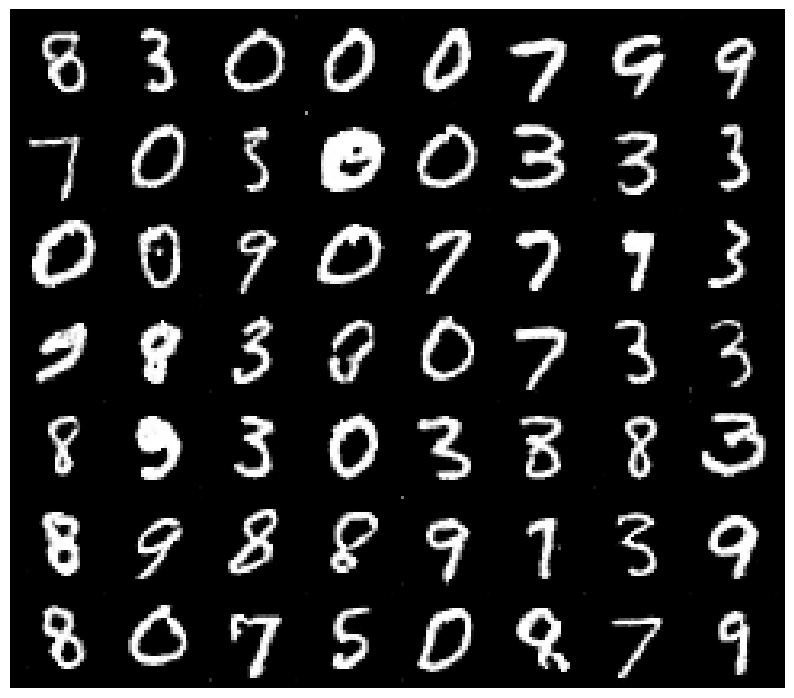

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.704, loss_G=1.92]


Epoch [140/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [140/400] - Average D loss: 0.6556, Average G loss: 1.9268


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.58it/s, loss_D=0.524, loss_G=2.1]


Epoch [141/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [141/400] - Average D loss: 0.6557, Average G loss: 1.9130


100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.602, loss_G=2]


Epoch [142/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [142/400] - Average D loss: 0.6548, Average G loss: 1.9187


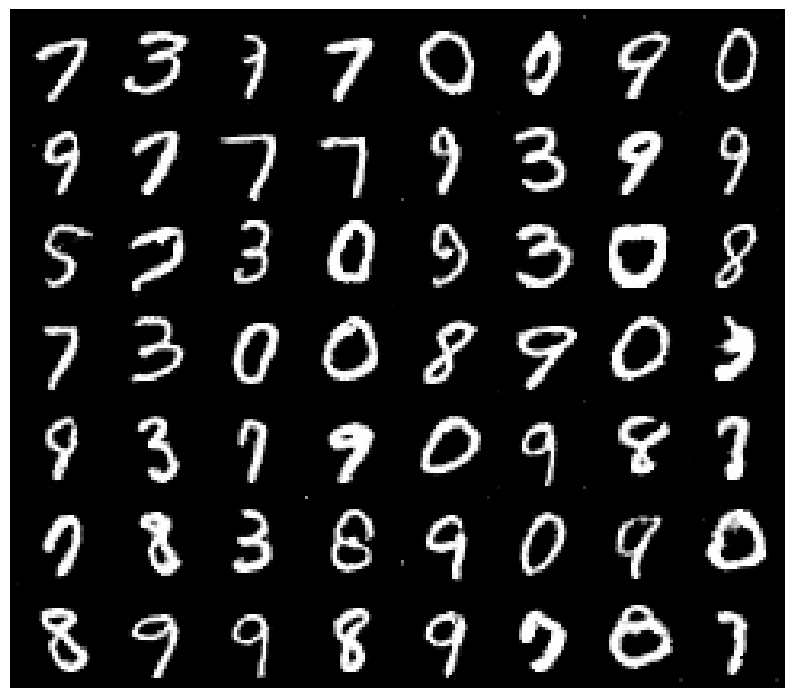

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.518, loss_G=1.99]


Epoch [143/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [143/400] - Average D loss: 0.6573, Average G loss: 1.9184


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.643, loss_G=2.12]


Epoch [144/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [144/400] - Average D loss: 0.6550, Average G loss: 1.9121


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.672, loss_G=1.54]


Epoch [145/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [145/400] - Average D loss: 0.6583, Average G loss: 1.9169


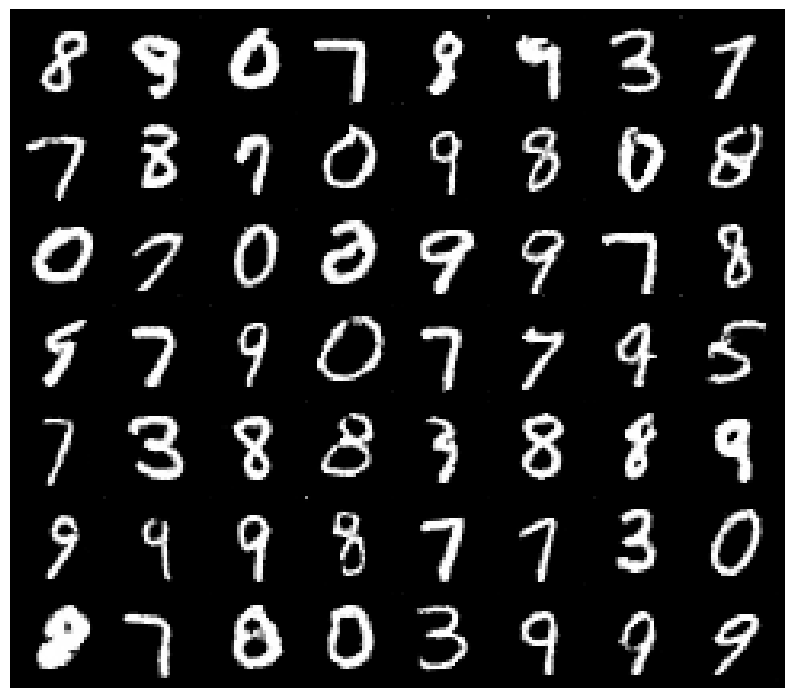

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.642, loss_G=1.92]


Epoch [146/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [146/400] - Average D loss: 0.6505, Average G loss: 1.9193


100%|██████████████████████████████████████████████████████| 732/732 [01:10<00:00, 10.39it/s, loss_D=0.85, loss_G=1.68]


Epoch [147/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [147/400] - Average D loss: 0.6558, Average G loss: 1.9236


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.67it/s, loss_D=0.642, loss_G=2.12]


Epoch [148/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [148/400] - Average D loss: 0.6528, Average G loss: 1.9207


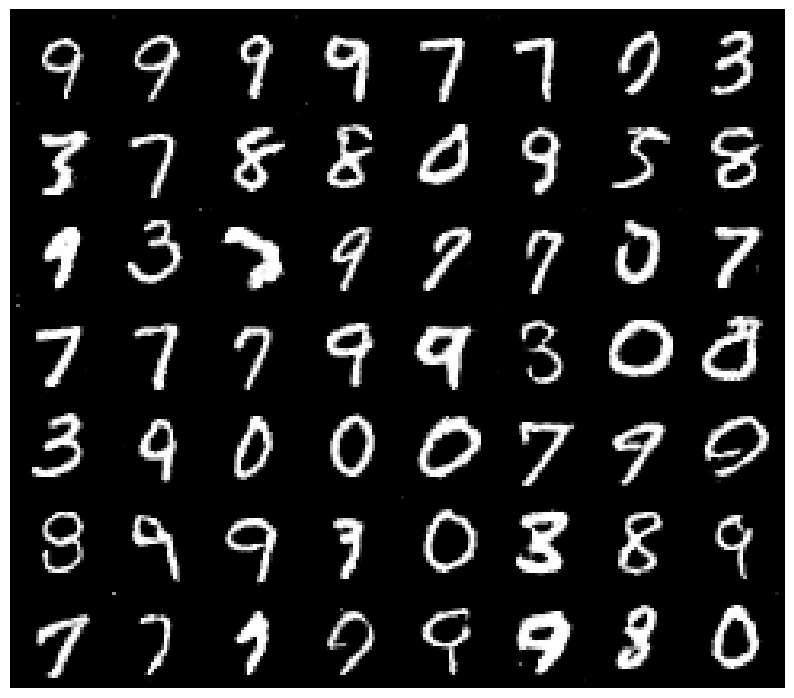

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=0.647, loss_G=1.75]


Epoch [149/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [149/400] - Average D loss: 0.6498, Average G loss: 1.9198


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.47, loss_G=2.08]


Epoch [150/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [150/400] - Average D loss: 0.6541, Average G loss: 1.9255


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.63, loss_G=1.99]


Epoch [151/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [151/400] - Average D loss: 0.6514, Average G loss: 1.9230


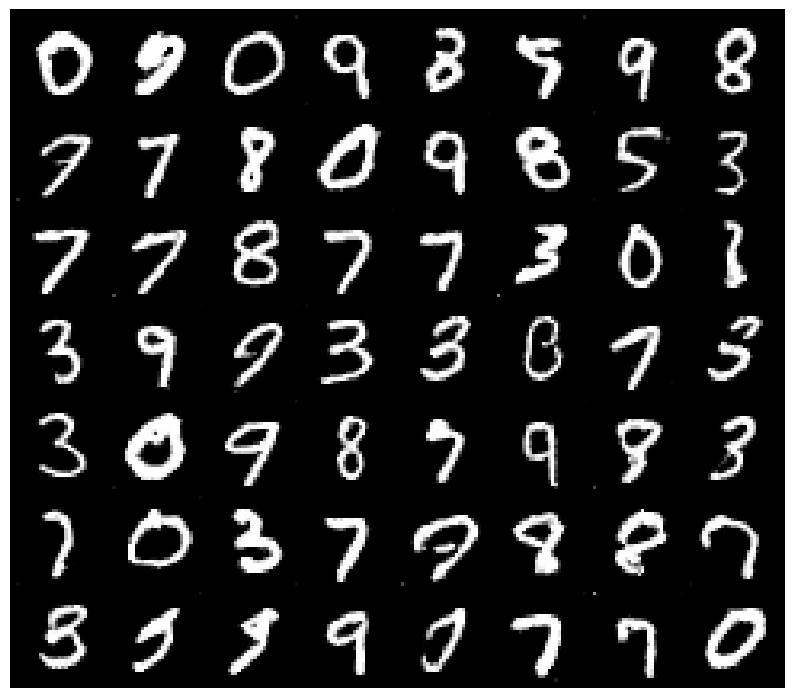

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.774, loss_G=1.88]


Epoch [152/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [152/400] - Average D loss: 0.6505, Average G loss: 1.9433


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.686, loss_G=2.03]


Epoch [153/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [153/400] - Average D loss: 0.6485, Average G loss: 1.9308


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.616, loss_G=1.93]


Epoch [154/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [154/400] - Average D loss: 0.6500, Average G loss: 1.9278


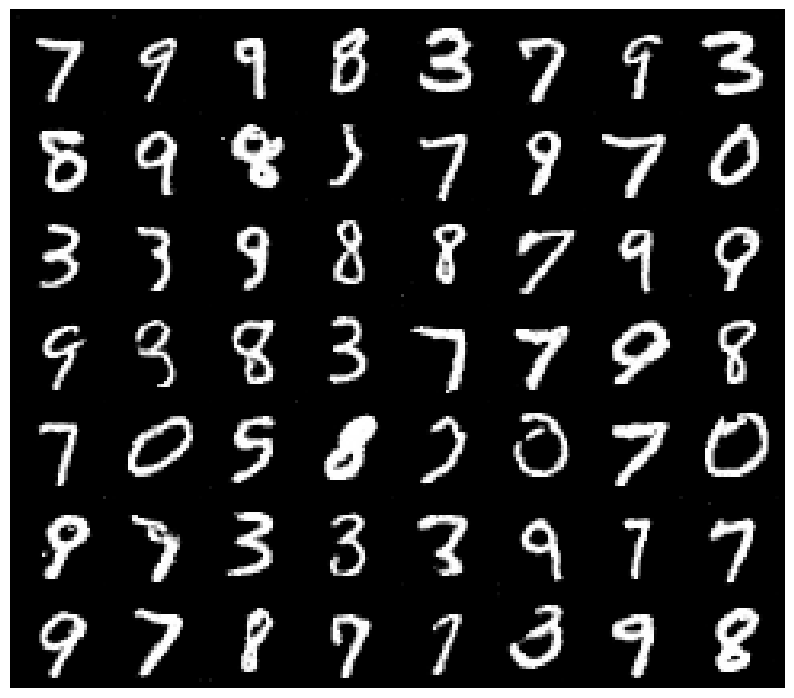

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.634, loss_G=1.9]


Epoch [155/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [155/400] - Average D loss: 0.6486, Average G loss: 1.9342


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.615, loss_G=2.03]


Epoch [156/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [156/400] - Average D loss: 0.6515, Average G loss: 1.9270


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.48it/s, loss_D=0.628, loss_G=1.88]


Epoch [157/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [157/400] - Average D loss: 0.6502, Average G loss: 1.9289


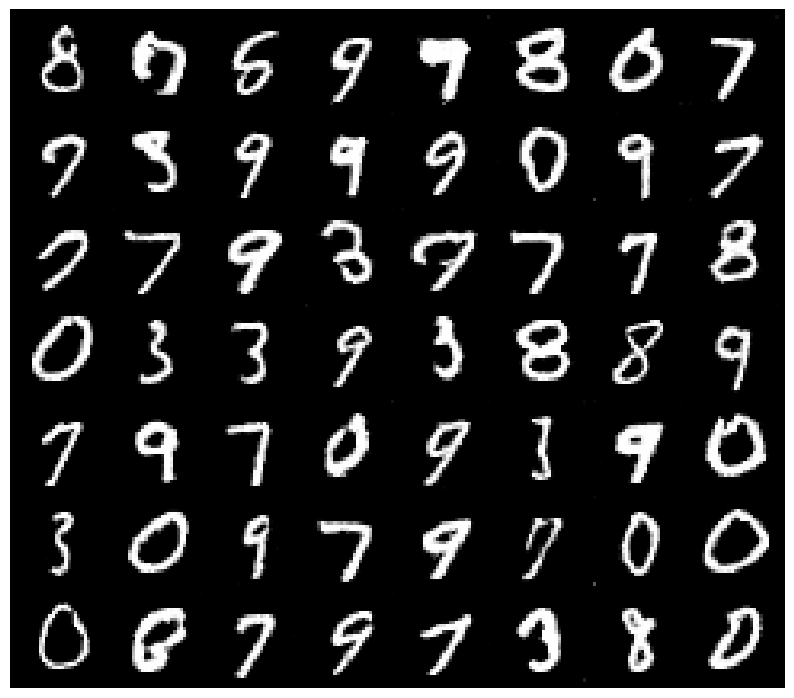

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.61it/s, loss_D=0.517, loss_G=2.06]


Epoch [158/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [158/400] - Average D loss: 0.6450, Average G loss: 1.9451


100%|██████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.53it/s, loss_D=0.58, loss_G=1.72]


Epoch [159/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [159/400] - Average D loss: 0.6520, Average G loss: 1.9395


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.69it/s, loss_D=0.625, loss_G=2.18]


Epoch [160/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [160/400] - Average D loss: 0.6510, Average G loss: 1.9344


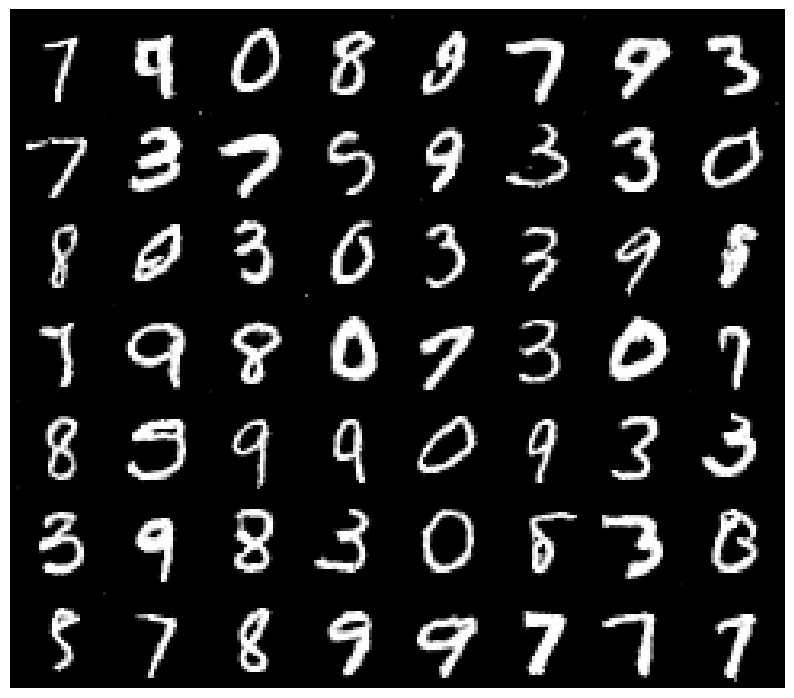

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.67it/s, loss_D=0.606, loss_G=1.97]


Epoch [161/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [161/400] - Average D loss: 0.6522, Average G loss: 1.9204


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.27it/s, loss_D=0.739, loss_G=1.86]


Epoch [162/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [162/400] - Average D loss: 0.6500, Average G loss: 1.9211


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.47it/s, loss_D=0.524, loss_G=2.01]


Epoch [163/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [163/400] - Average D loss: 0.6452, Average G loss: 1.9366


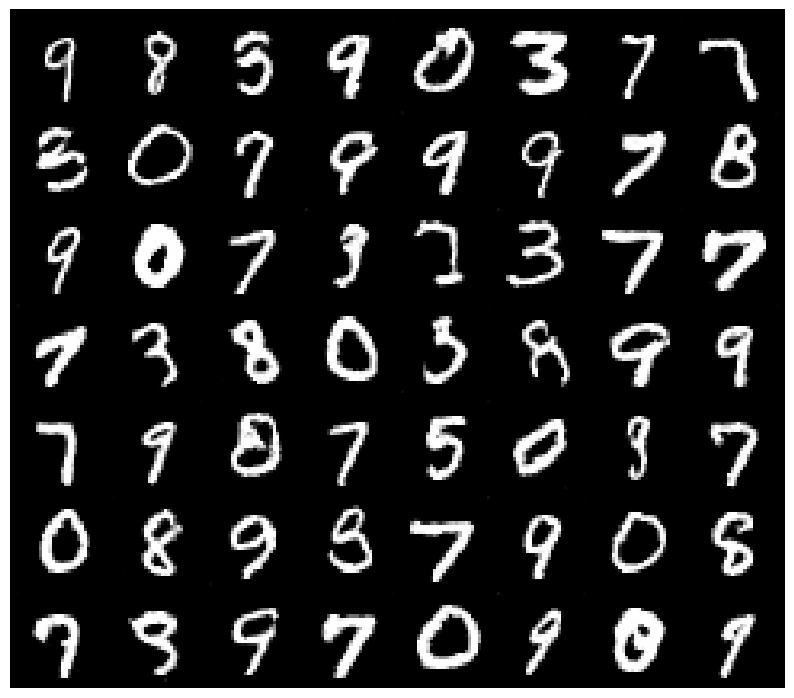

100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.36it/s, loss_D=0.752, loss_G=2.09]


Epoch [164/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [164/400] - Average D loss: 0.6472, Average G loss: 1.9397


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.11it/s, loss_D=0.691, loss_G=2.12]


Epoch [165/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [165/400] - Average D loss: 0.6507, Average G loss: 1.9275


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.46it/s, loss_D=0.722, loss_G=1.76]


Epoch [166/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [166/400] - Average D loss: 0.6518, Average G loss: 1.9320


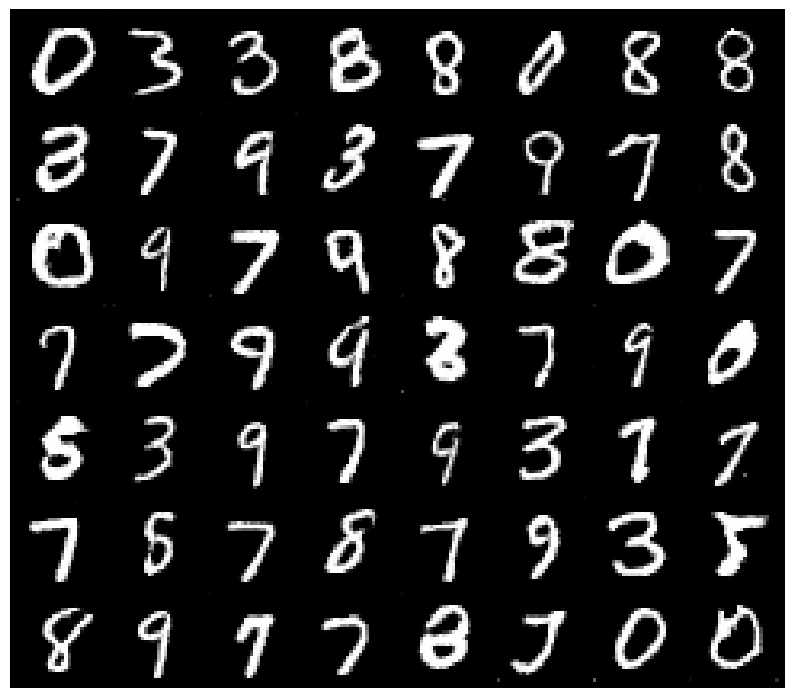

100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.33it/s, loss_D=0.596, loss_G=1.67]


Epoch [167/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [167/400] - Average D loss: 0.6458, Average G loss: 1.9287


100%|███████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.09it/s, loss_D=0.55, loss_G=2.1]


Epoch [168/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [168/400] - Average D loss: 0.6501, Average G loss: 1.9257


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.18it/s, loss_D=0.446, loss_G=2.43]


Epoch [169/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [169/400] - Average D loss: 0.6505, Average G loss: 1.9333


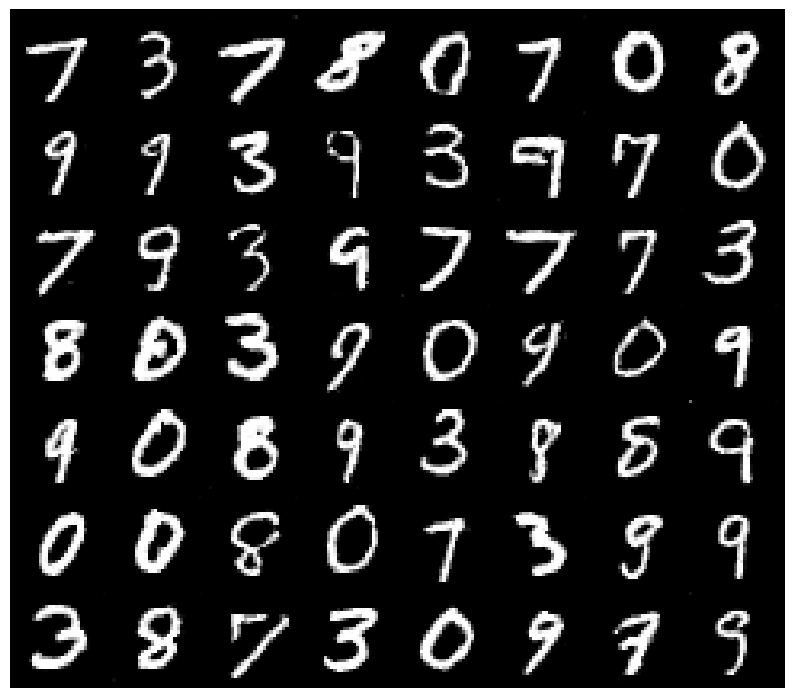

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.13it/s, loss_D=0.745, loss_G=1.65]


Epoch [170/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [170/400] - Average D loss: 0.6458, Average G loss: 1.9437


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.25it/s, loss_D=0.684, loss_G=2.06]


Epoch [171/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [171/400] - Average D loss: 0.6445, Average G loss: 1.9413


100%|██████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.07it/s, loss_D=0.53, loss_G=1.87]


Epoch [172/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [172/400] - Average D loss: 0.6431, Average G loss: 1.9474


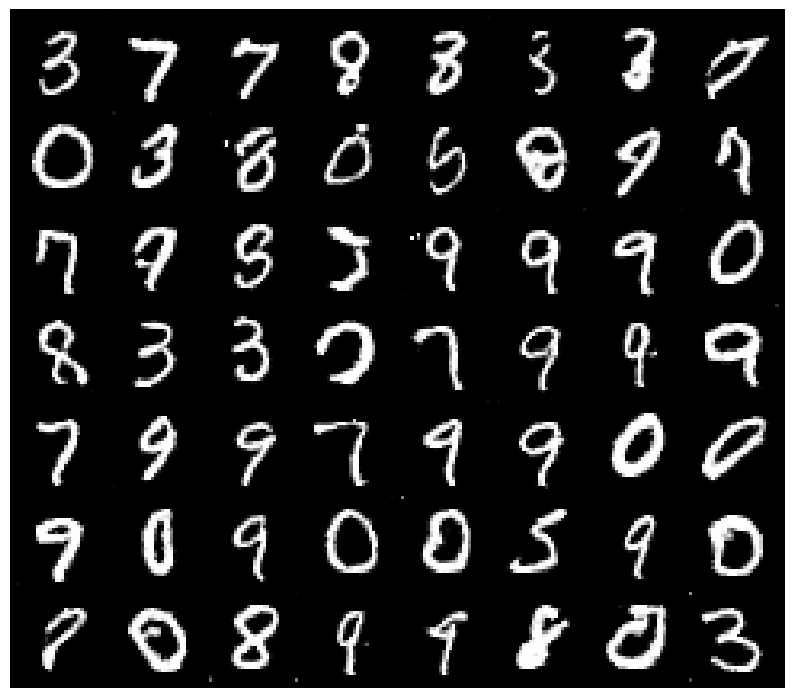

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.23it/s, loss_D=0.629, loss_G=1.94]


Epoch [173/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [173/400] - Average D loss: 0.6445, Average G loss: 1.9439


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.08it/s, loss_D=0.624, loss_G=1.82]


Epoch [174/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [174/400] - Average D loss: 0.6443, Average G loss: 1.9387


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.05it/s, loss_D=0.662, loss_G=1.93]


Epoch [175/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [175/400] - Average D loss: 0.6446, Average G loss: 1.9450


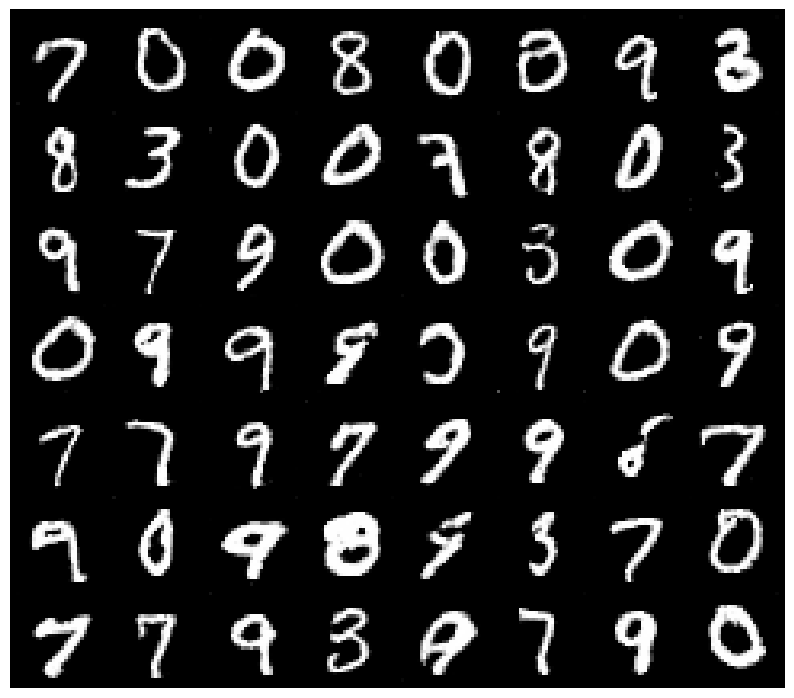

100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.03it/s, loss_D=0.705, loss_G=2.14]


Epoch [176/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [176/400] - Average D loss: 0.6467, Average G loss: 1.9396


100%|██████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.15it/s, loss_D=0.64, loss_G=2.03]


Epoch [177/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [177/400] - Average D loss: 0.6442, Average G loss: 1.9462


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.11it/s, loss_D=0.776, loss_G=1.78]


Epoch [178/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [178/400] - Average D loss: 0.6423, Average G loss: 1.9394


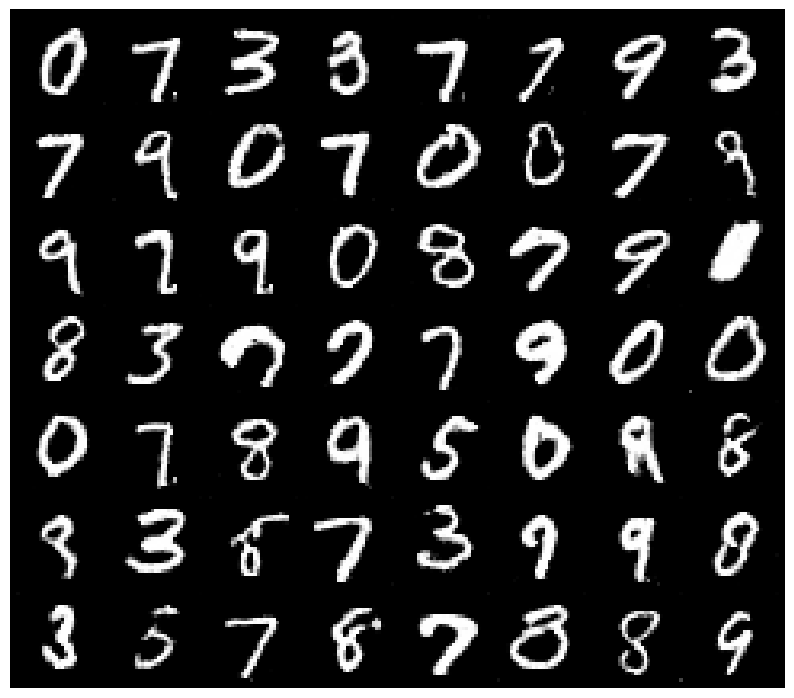

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.08it/s, loss_D=0.568, loss_G=1.99]


Epoch [179/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [179/400] - Average D loss: 0.6480, Average G loss: 1.9473


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.10it/s, loss_D=0.642, loss_G=1.97]


Epoch [180/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [180/400] - Average D loss: 0.6430, Average G loss: 1.9482


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.98it/s, loss_D=0.761, loss_G=2.23]


Epoch [181/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [181/400] - Average D loss: 0.6431, Average G loss: 1.9417


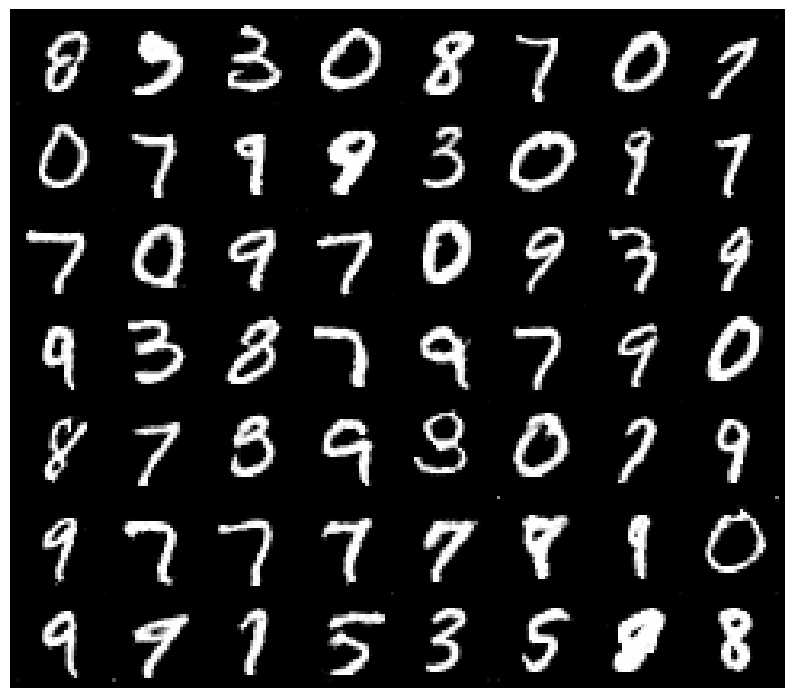

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.11it/s, loss_D=0.732, loss_G=1.99]


Epoch [182/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [182/400] - Average D loss: 0.6477, Average G loss: 1.9302


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.84it/s, loss_D=0.653, loss_G=1.84]


Epoch [183/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [183/400] - Average D loss: 0.6430, Average G loss: 1.9434


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.19it/s, loss_D=0.716, loss_G=2.22]


Epoch [184/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [184/400] - Average D loss: 0.6453, Average G loss: 1.9295


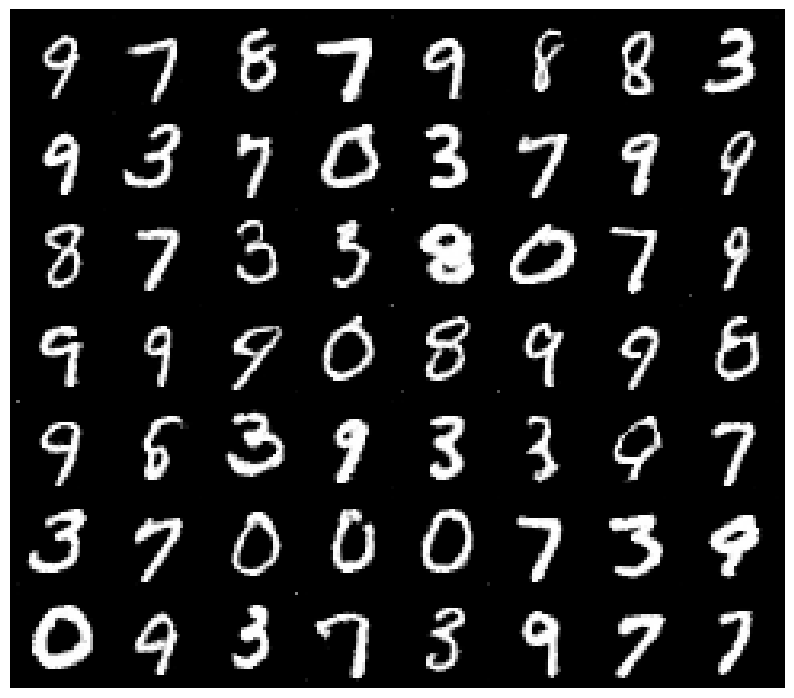

100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.05it/s, loss_D=0.419, loss_G=1.91]


Epoch [185/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [185/400] - Average D loss: 0.6412, Average G loss: 1.9419


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.08it/s, loss_D=0.683, loss_G=2.05]


Epoch [186/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [186/400] - Average D loss: 0.6401, Average G loss: 1.9464


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.17it/s, loss_D=0.552, loss_G=2.02]


Epoch [187/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [187/400] - Average D loss: 0.6447, Average G loss: 1.9461


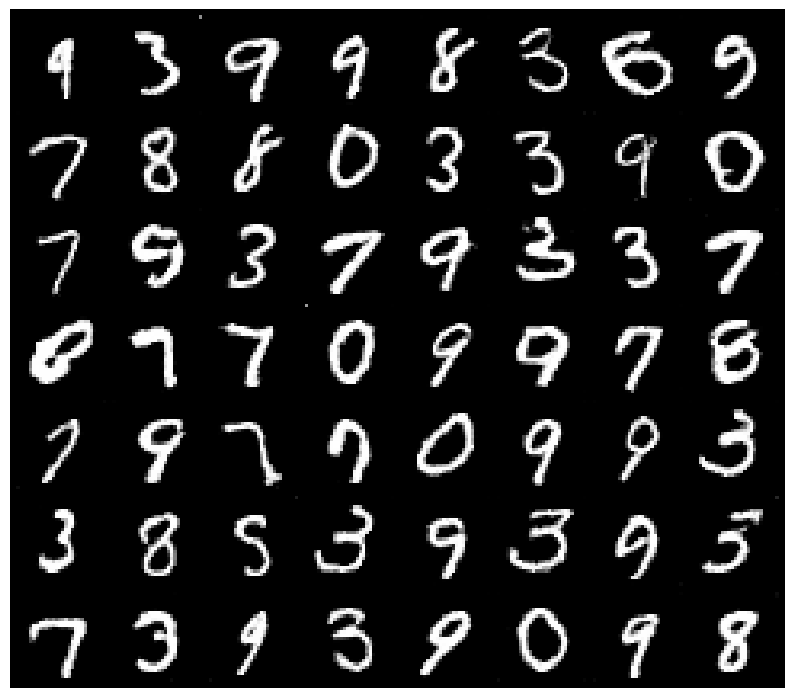

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.07it/s, loss_D=0.716, loss_G=1.79]


Epoch [188/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [188/400] - Average D loss: 0.6410, Average G loss: 1.9391


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.10it/s, loss_D=0.683, loss_G=1.92]


Epoch [189/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [189/400] - Average D loss: 0.6410, Average G loss: 1.9462


100%|█████████████████████████████████████████████████████| 732/732 [00:57<00:00, 12.77it/s, loss_D=0.622, loss_G=1.86]


Epoch [190/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [190/400] - Average D loss: 0.6415, Average G loss: 1.9456


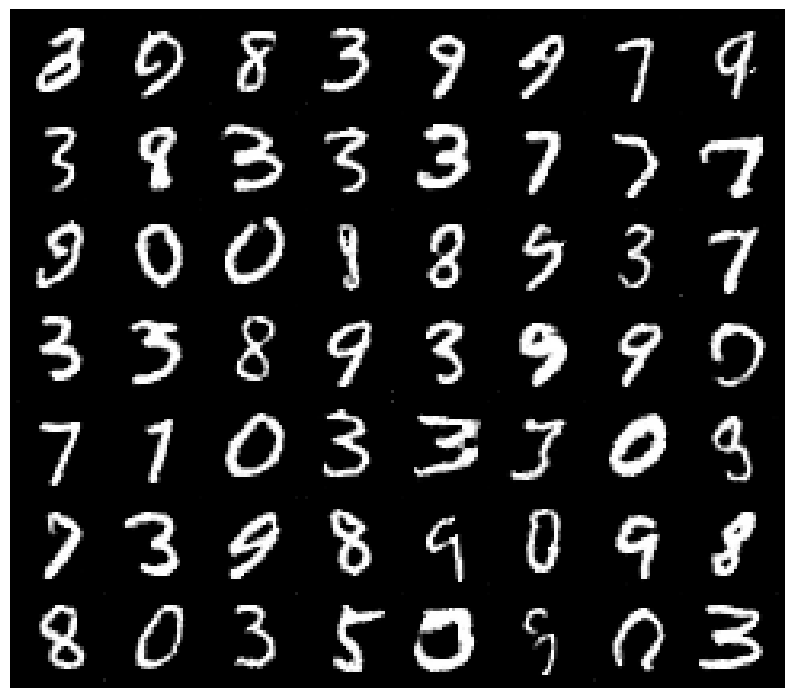

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.19it/s, loss_D=0.797, loss_G=1.93]


Epoch [191/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [191/400] - Average D loss: 0.6399, Average G loss: 1.9442


100%|██████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.90it/s, loss_D=0.58, loss_G=1.94]


Epoch [192/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [192/400] - Average D loss: 0.6410, Average G loss: 1.9539


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.07it/s, loss_D=0.806, loss_G=1.87]


Epoch [193/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [193/400] - Average D loss: 0.6442, Average G loss: 1.9442


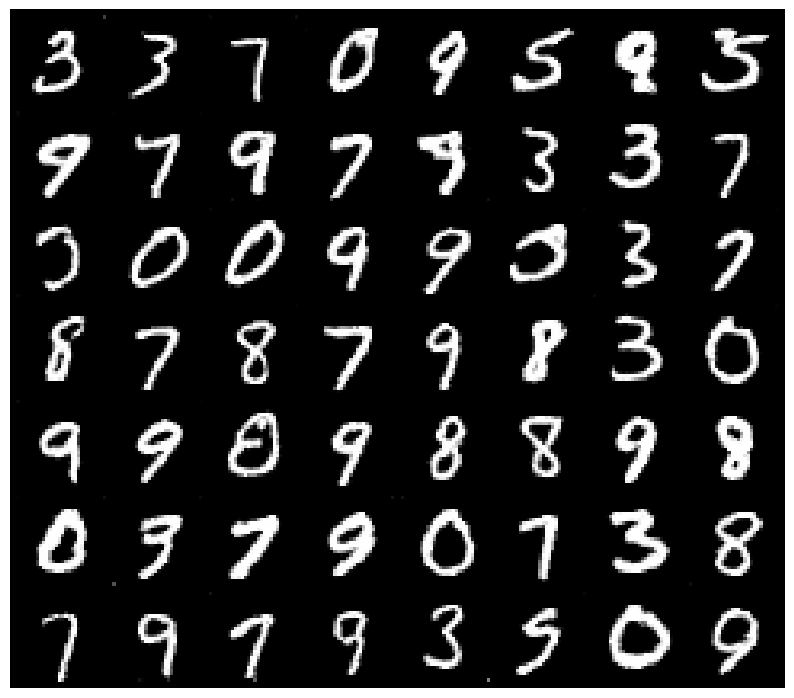

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.14it/s, loss_D=0.526, loss_G=1.95]


Epoch [194/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [194/400] - Average D loss: 0.6418, Average G loss: 1.9500


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.95it/s, loss_D=0.588, loss_G=1.88]


Epoch [195/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [195/400] - Average D loss: 0.6418, Average G loss: 1.9465


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.02it/s, loss_D=0.667, loss_G=1.94]


Epoch [196/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [196/400] - Average D loss: 0.6404, Average G loss: 1.9461


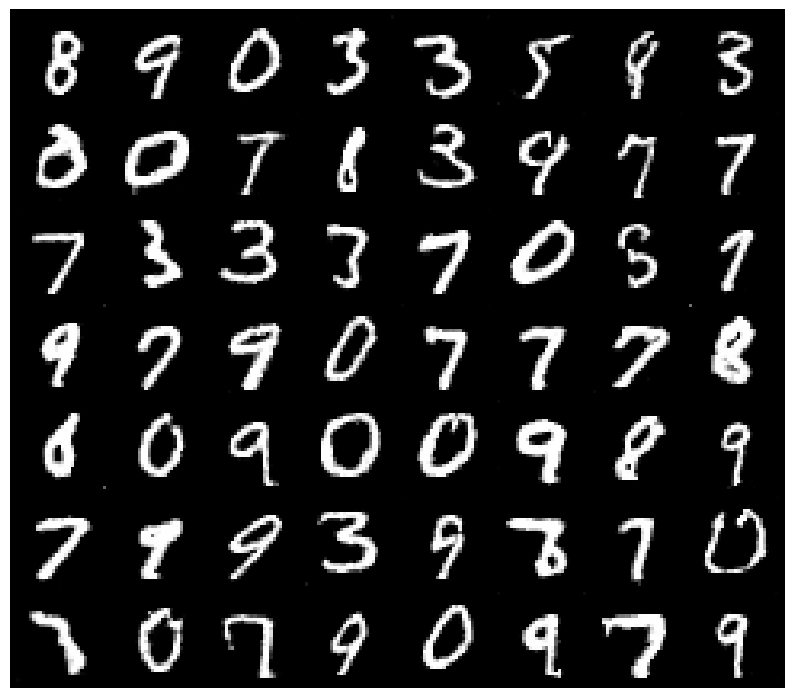

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.27it/s, loss_D=0.662, loss_G=2.07]


Epoch [197/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [197/400] - Average D loss: 0.6416, Average G loss: 1.9547


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.21it/s, loss_D=0.803, loss_G=1.76]


Epoch [198/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [198/400] - Average D loss: 0.6410, Average G loss: 1.9446


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.99it/s, loss_D=0.584, loss_G=1.71]


Epoch [199/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [199/400] - Average D loss: 0.6436, Average G loss: 1.9417


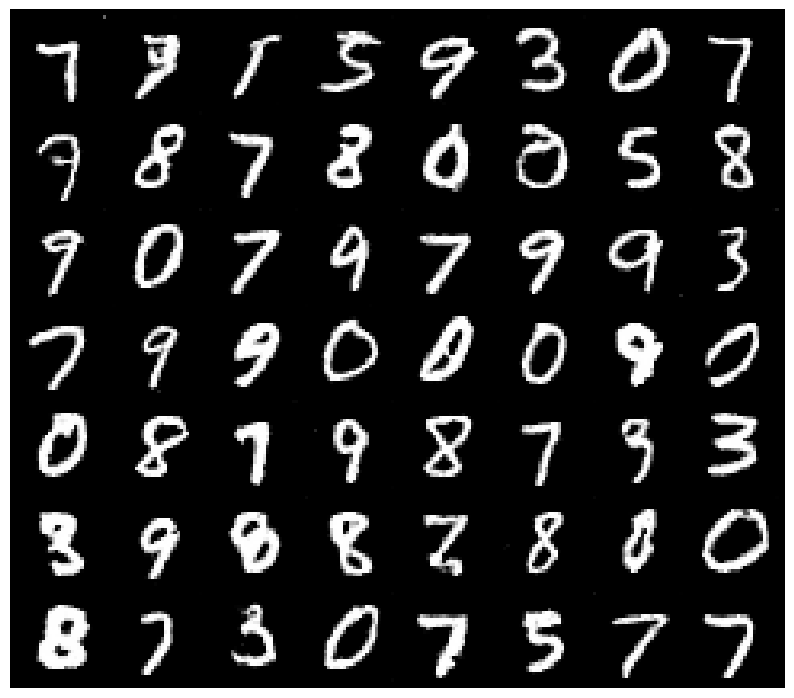

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.24it/s, loss_D=0.622, loss_G=1.87]


Epoch [200/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [200/400] - Average D loss: 0.6402, Average G loss: 1.9583


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.16it/s, loss_D=0.648, loss_G=1.73]


Epoch [201/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [201/400] - Average D loss: 0.6381, Average G loss: 1.9532


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.702, loss_G=1.75]


Epoch [202/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [202/400] - Average D loss: 0.6395, Average G loss: 1.9487


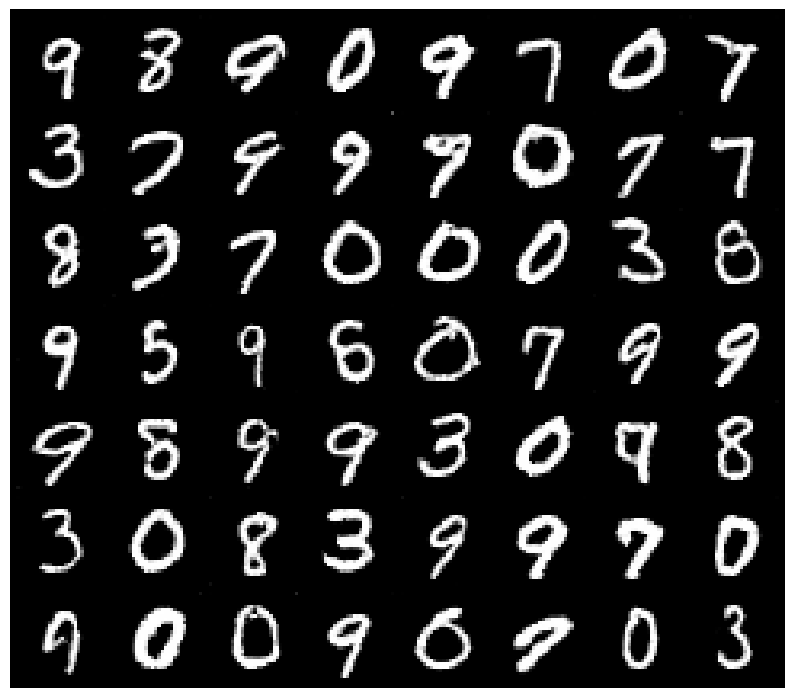

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.695, loss_G=1.79]


Epoch [203/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [203/400] - Average D loss: 0.6414, Average G loss: 1.9460


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.516, loss_G=2.12]


Epoch [204/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [204/400] - Average D loss: 0.6394, Average G loss: 1.9527


100%|█████████████████████████████████████████████████████| 732/732 [39:41<00:00,  3.25s/it, loss_D=0.804, loss_G=2.11]


Epoch [271/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [271/400] - Average D loss: 0.6327, Average G loss: 1.9533


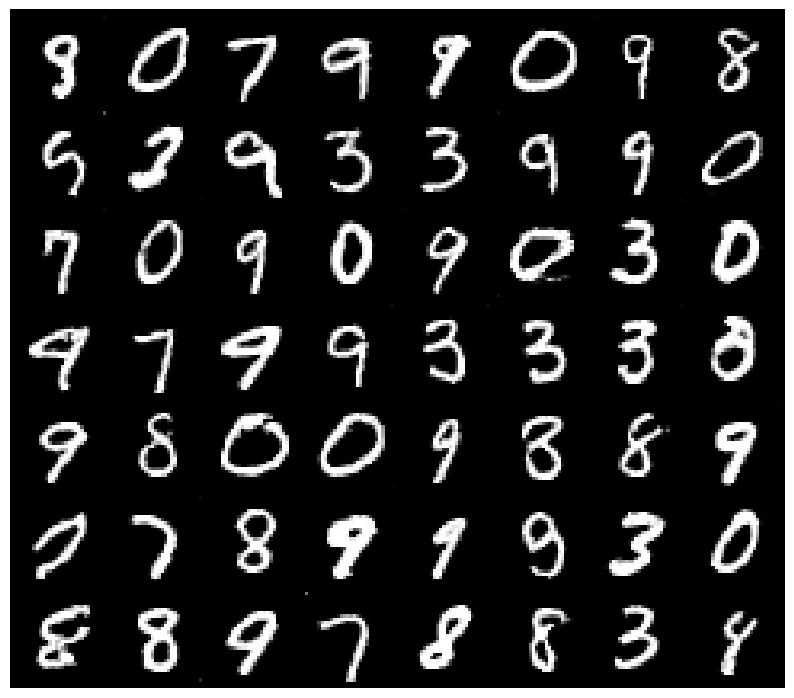

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.71, loss_G=1.83]


Epoch [272/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [272/400] - Average D loss: 0.6311, Average G loss: 1.9583


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.589, loss_G=2.03]


Epoch [275/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [275/400] - Average D loss: 0.6338, Average G loss: 1.9552


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.644, loss_G=2.11]


Epoch [276/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [276/400] - Average D loss: 0.6327, Average G loss: 1.9716


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.556, loss_G=2.28]


Epoch [280/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [280/400] - Average D loss: 0.6308, Average G loss: 1.9558


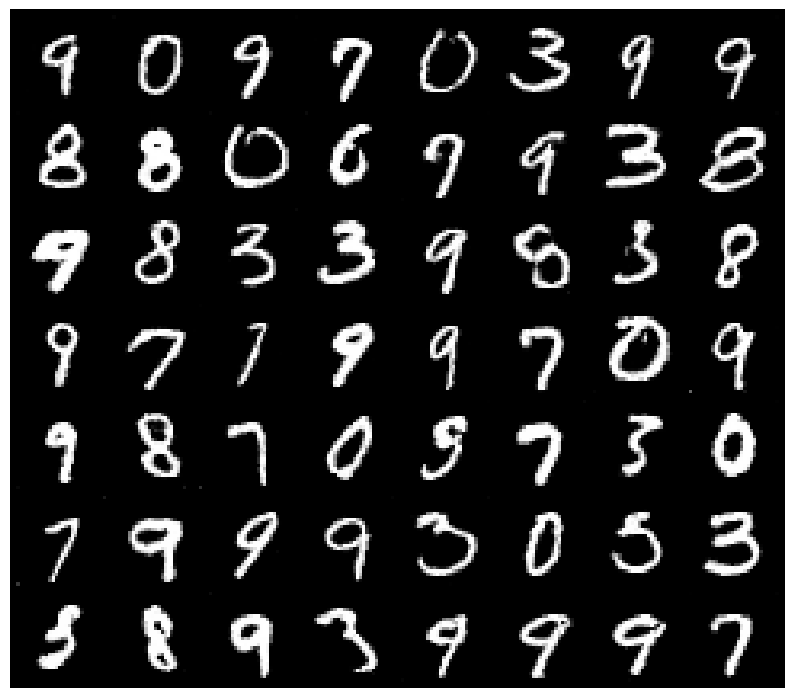

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.708, loss_G=1.97]


Epoch [281/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [281/400] - Average D loss: 0.6335, Average G loss: 1.9597


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.28it/s, loss_D=0.714, loss_G=2.05]


Epoch [285/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [285/400] - Average D loss: 0.6318, Average G loss: 1.9476


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.63, loss_G=1.91]


Epoch [286/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [286/400] - Average D loss: 0.6277, Average G loss: 1.9629


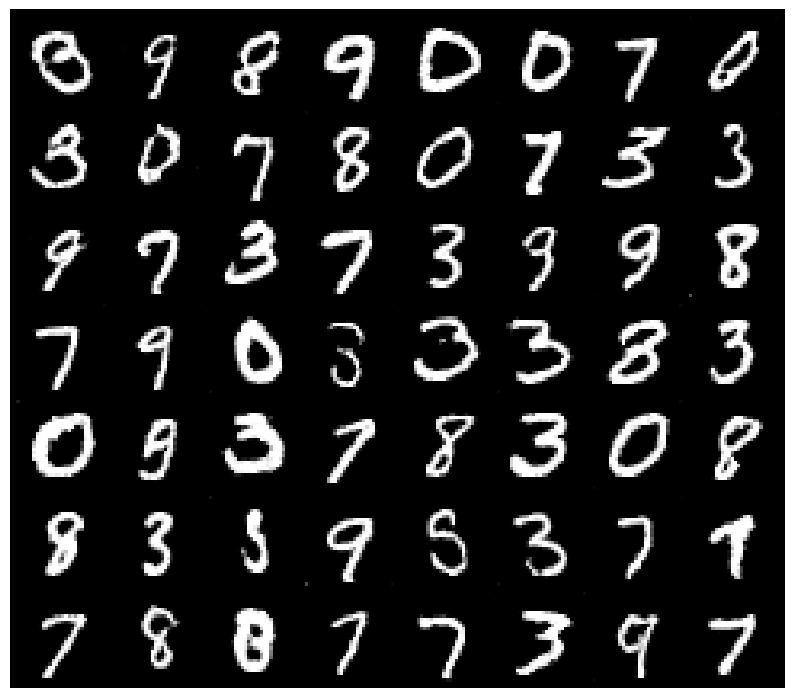

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.637, loss_G=1.79]


Epoch [289/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [289/400] - Average D loss: 0.6329, Average G loss: 1.9574


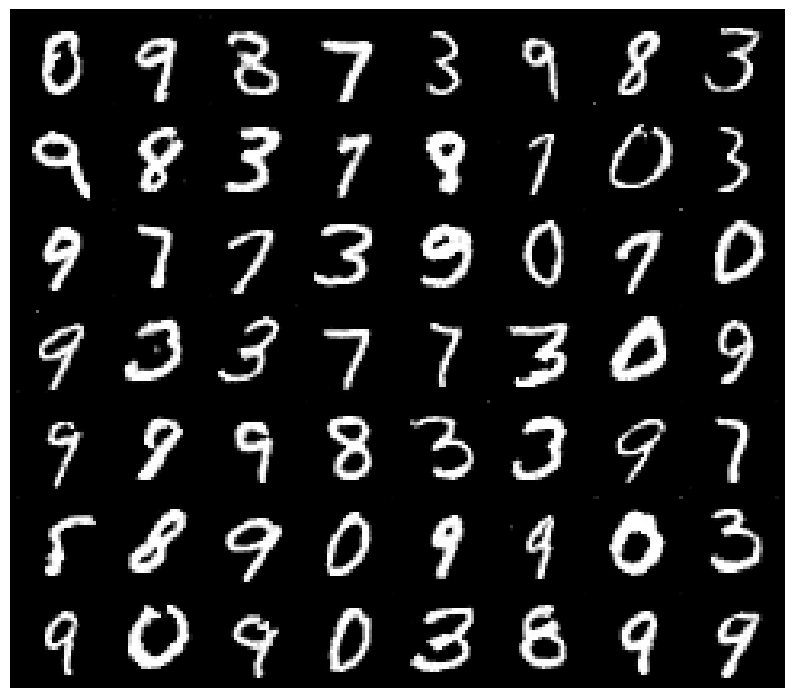

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.27it/s, loss_D=0.658, loss_G=2.22]


Epoch [290/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [290/400] - Average D loss: 0.6397, Average G loss: 1.9660


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.597, loss_G=2.25]


Epoch [291/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [291/400] - Average D loss: 0.6320, Average G loss: 1.9511


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.534, loss_G=1.81]


Epoch [295/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [295/400] - Average D loss: 0.6328, Average G loss: 1.9540


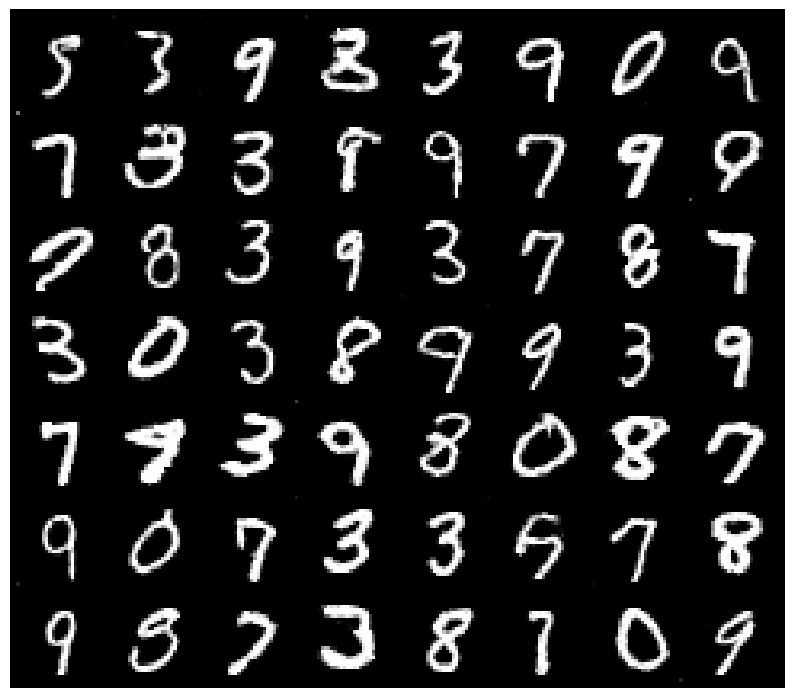

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.538, loss_G=1.93]


Epoch [299/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [299/400] - Average D loss: 0.6316, Average G loss: 1.9555


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.623, loss_G=1.76]


Epoch [300/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [300/400] - Average D loss: 0.6310, Average G loss: 1.9622


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.647, loss_G=2.05]


Epoch [304/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [304/400] - Average D loss: 0.6312, Average G loss: 1.9548


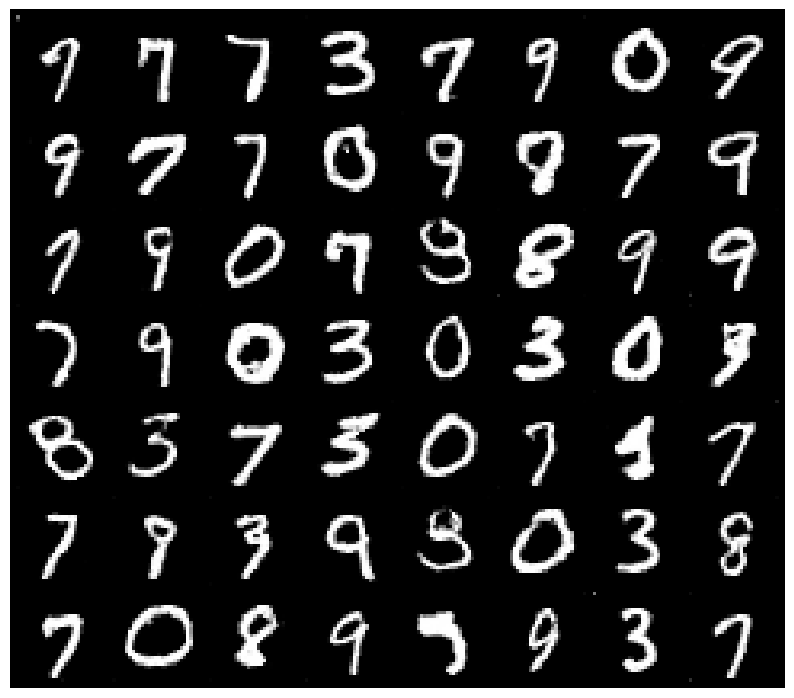

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.657, loss_G=2.16]


Epoch [305/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [305/400] - Average D loss: 0.6371, Average G loss: 1.9549


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.638, loss_G=1.88]


Epoch [309/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [309/400] - Average D loss: 0.6321, Average G loss: 1.9689


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.525, loss_G=2.33]


Epoch [310/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [310/400] - Average D loss: 0.6338, Average G loss: 1.9647


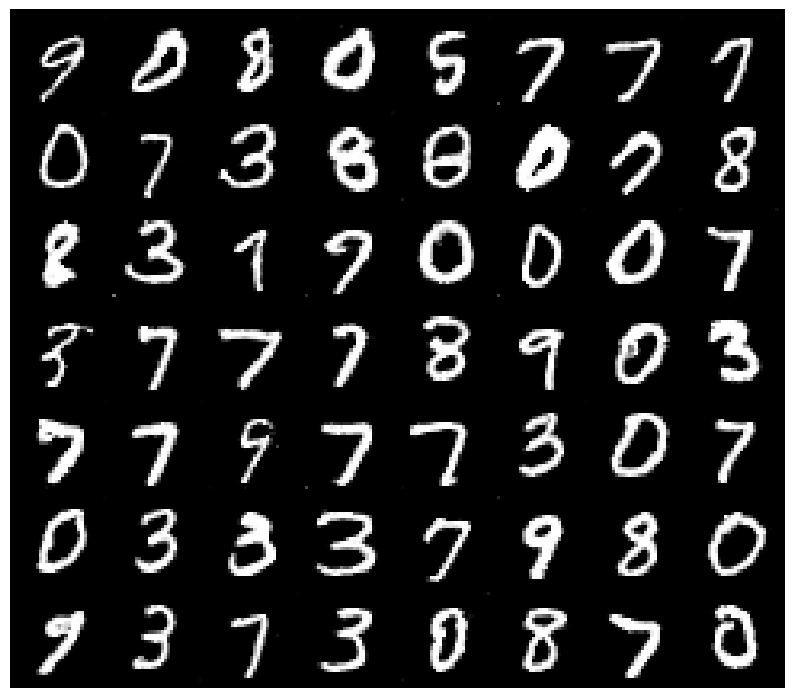

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.773, loss_G=1.85]


Epoch [313/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [313/400] - Average D loss: 0.6300, Average G loss: 1.9573


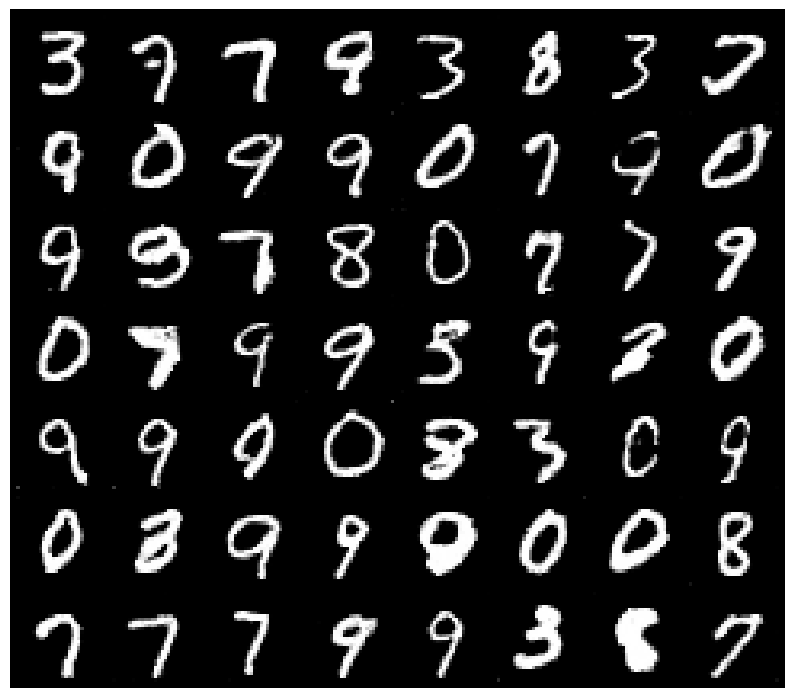

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.591, loss_G=1.86]


Epoch [314/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [314/400] - Average D loss: 0.6290, Average G loss: 1.9661


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.772, loss_G=1.89]


Epoch [318/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [318/400] - Average D loss: 0.6328, Average G loss: 1.9549


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.514, loss_G=1.94]


Epoch [319/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [319/400] - Average D loss: 0.6330, Average G loss: 1.9519


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.49it/s, loss_D=0.647, loss_G=1.83]


Epoch [323/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [323/400] - Average D loss: 0.6314, Average G loss: 1.9630


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.686, loss_G=2.25]


Epoch [327/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [327/400] - Average D loss: 0.6305, Average G loss: 1.9540


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.789, loss_G=1.89]


Epoch [328/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [328/400] - Average D loss: 0.6309, Average G loss: 1.9718


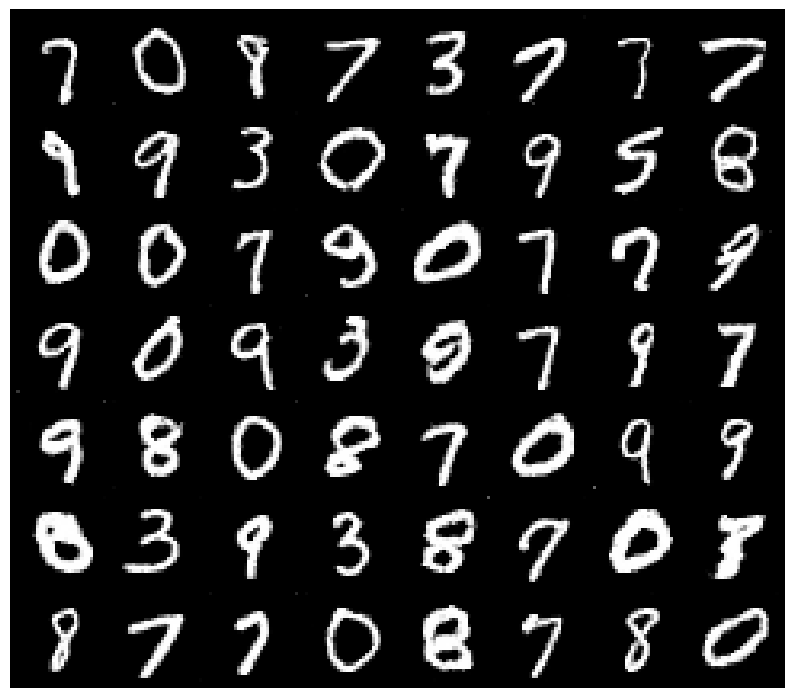

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.547, loss_G=1.75]


Epoch [332/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [332/400] - Average D loss: 0.6293, Average G loss: 1.9603


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.696, loss_G=1.83]


Epoch [333/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [333/400] - Average D loss: 0.6314, Average G loss: 1.9515


100%|█████████████████████████████████████████████████████| 732/732 [01:10<00:00, 10.31it/s, loss_D=0.683, loss_G=1.92]


Epoch [336/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [336/400] - Average D loss: 0.6311, Average G loss: 1.9588


100%|█████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.29it/s, loss_D=0.562, loss_G=2.08]


Epoch [337/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [337/400] - Average D loss: 0.6301, Average G loss: 1.9529


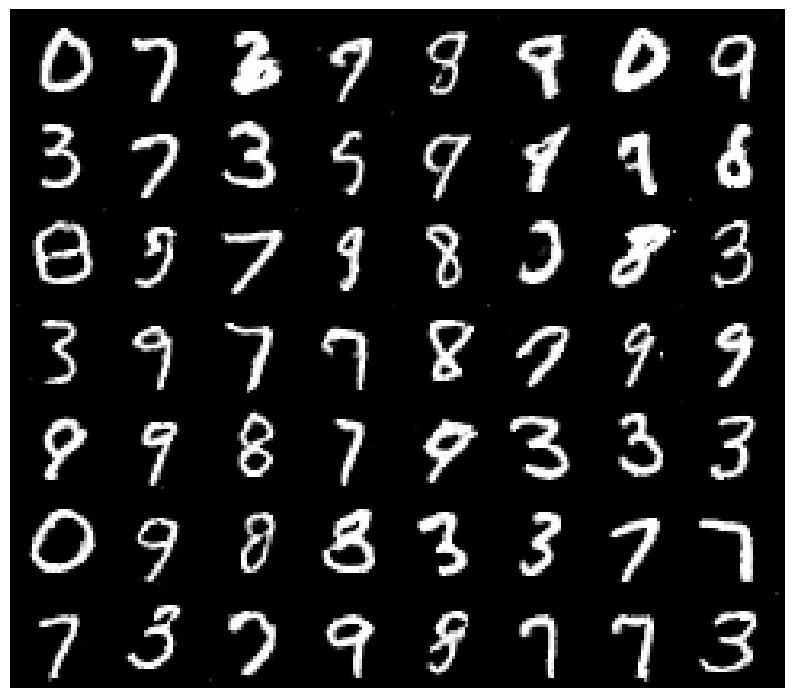

100%|██████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.21it/s, loss_D=0.58, loss_G=1.94]


Epoch [341/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [341/400] - Average D loss: 0.6262, Average G loss: 1.9612


100%|██████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.99it/s, loss_D=0.64, loss_G=2.34]


Epoch [345/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [345/400] - Average D loss: 0.6289, Average G loss: 1.9598


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.19it/s, loss_D=0.642, loss_G=2.01]


Epoch [349/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [349/400] - Average D loss: 0.6301, Average G loss: 1.9625


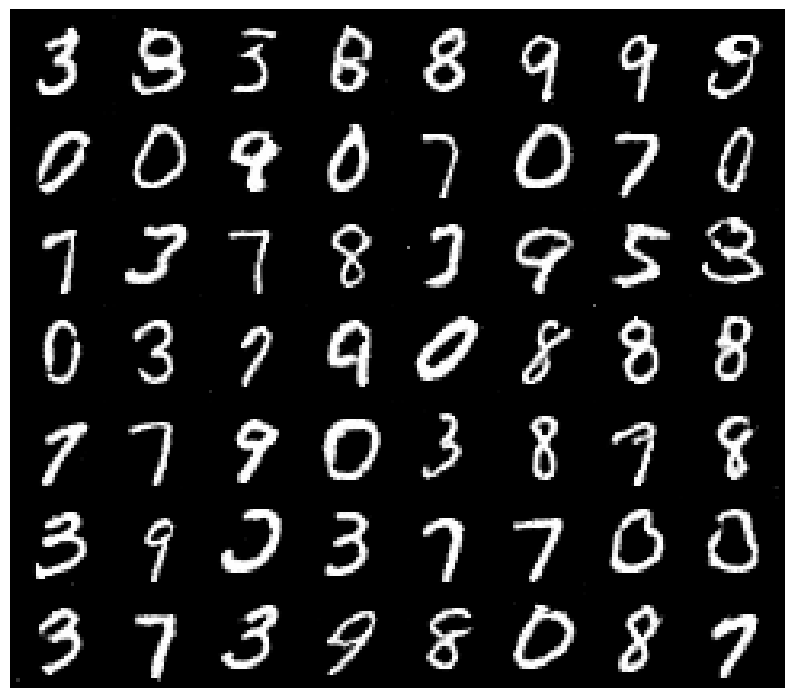

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.26it/s, loss_D=0.681, loss_G=1.96]


Epoch [350/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [350/400] - Average D loss: 0.6301, Average G loss: 1.9581


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.37it/s, loss_D=0.684, loss_G=1.86]


Epoch [354/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [354/400] - Average D loss: 0.6291, Average G loss: 1.9611


100%|██████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.45it/s, loss_D=0.573, loss_G=1.9]


Epoch [358/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [358/400] - Average D loss: 0.6283, Average G loss: 1.9633


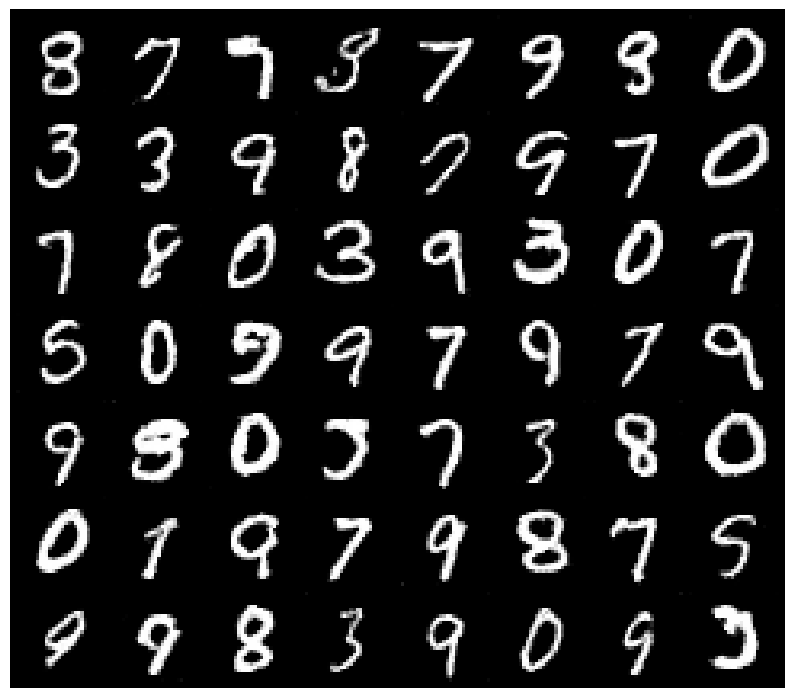

100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.53it/s, loss_D=0.538, loss_G=2.02]


Epoch [359/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [359/400] - Average D loss: 0.6267, Average G loss: 1.9631


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.32it/s, loss_D=0.664, loss_G=1.79]


Epoch [363/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [363/400] - Average D loss: 0.6292, Average G loss: 1.9529


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.51it/s, loss_D=0.598, loss_G=2.02]


Epoch [367/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [367/400] - Average D loss: 0.6260, Average G loss: 1.9615


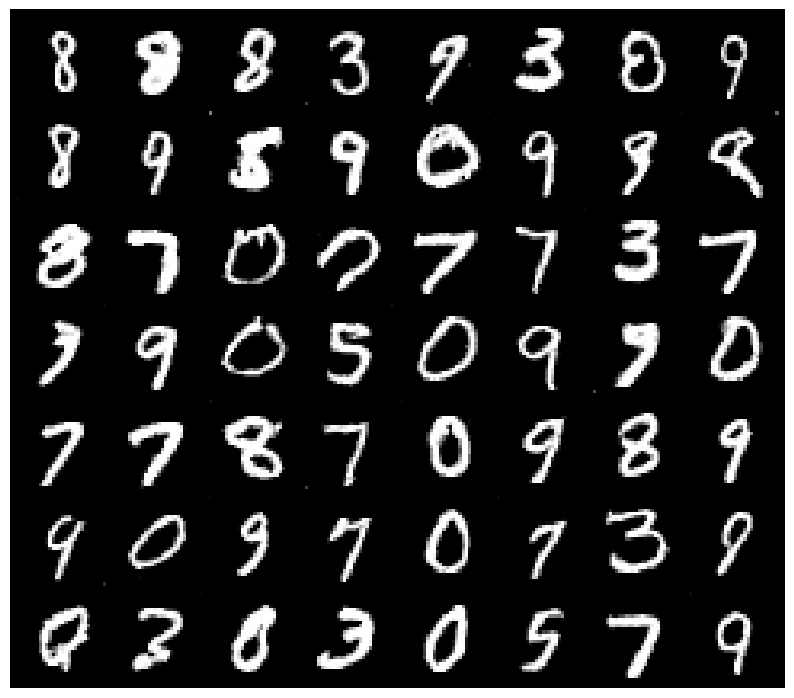

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.529, loss_G=2.02]


Epoch [368/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [368/400] - Average D loss: 0.6300, Average G loss: 1.9594


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.608, loss_G=1.9]


Epoch [373/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [373/400] - Average D loss: 0.6345, Average G loss: 1.9422


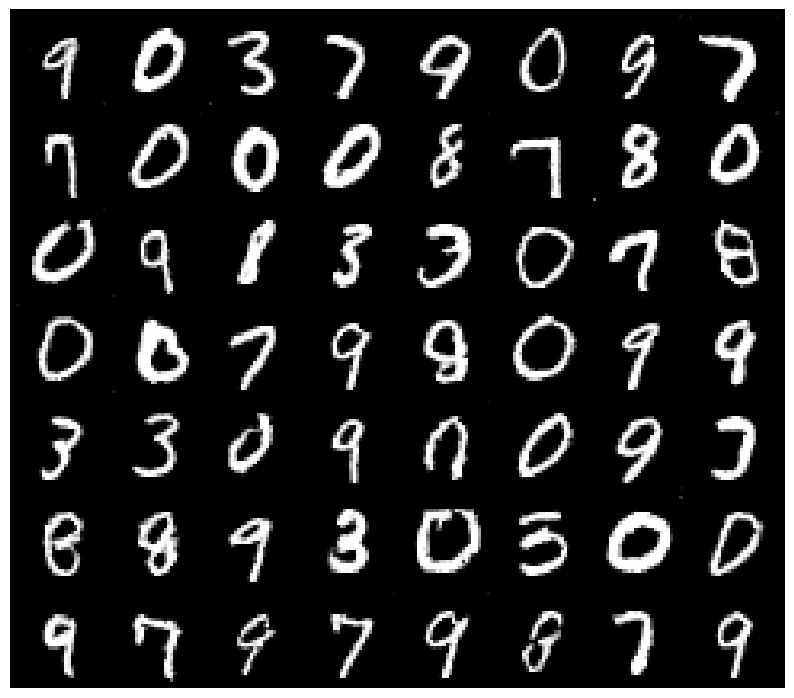

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.08it/s, loss_D=0.658, loss_G=1.98]


Epoch [377/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [377/400] - Average D loss: 0.6326, Average G loss: 1.9479


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.622, loss_G=1.92]


Epoch [378/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [378/400] - Average D loss: 0.6294, Average G loss: 1.9558


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.601, loss_G=2.32]


Epoch [382/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [382/400] - Average D loss: 0.6260, Average G loss: 1.9672


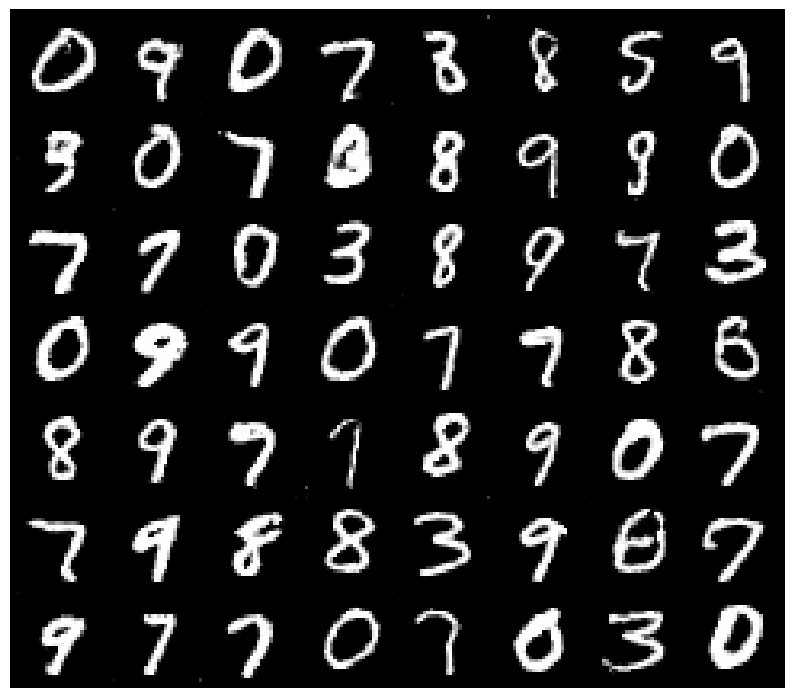

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.655, loss_G=1.78]


Epoch [383/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [383/400] - Average D loss: 0.6287, Average G loss: 1.9711


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.762, loss_G=1.84]


Epoch [387/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [387/400] - Average D loss: 0.6271, Average G loss: 1.9675


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.19it/s, loss_D=0.635, loss_G=2.08]


Epoch [388/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [388/400] - Average D loss: 0.6294, Average G loss: 1.9554


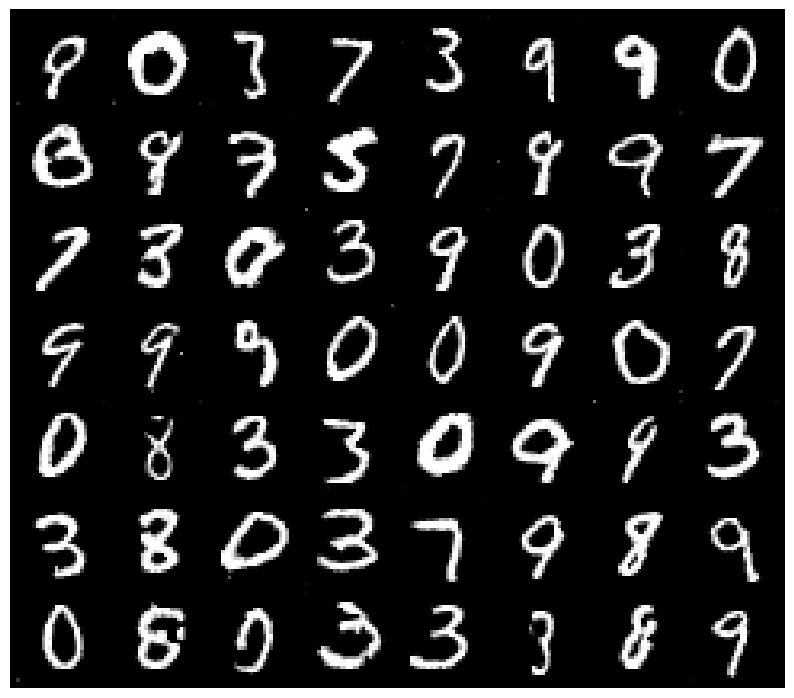

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.527, loss_G=2.07]


Epoch [392/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [392/400] - Average D loss: 0.6248, Average G loss: 1.9611


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.565, loss_G=2.09]


Epoch [393/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [393/400] - Average D loss: 0.6311, Average G loss: 1.9583


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.62it/s, loss_D=0.752, loss_G=1.92]


Epoch [394/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [394/400] - Average D loss: 0.6276, Average G loss: 1.9620


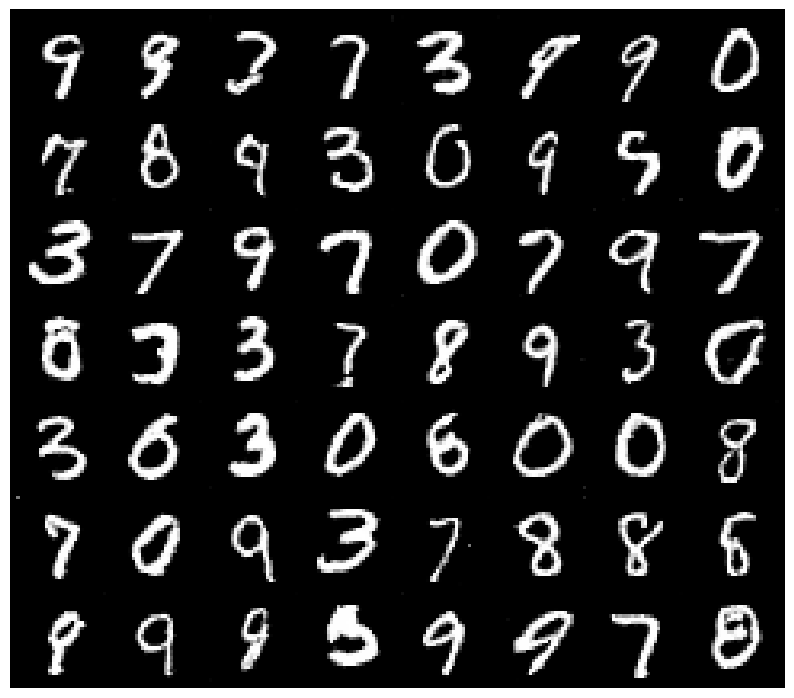

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.696, loss_G=2.02]


Epoch [397/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [397/400] - Average D loss: 0.6267, Average G loss: 1.9620


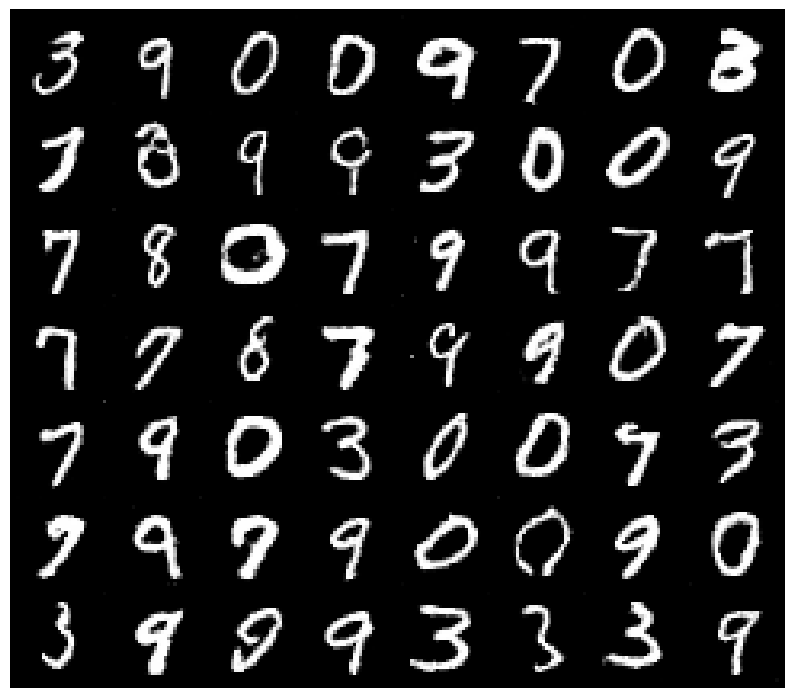

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.482, loss_G=1.85]


Epoch [398/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [398/400] - Average D loss: 0.6273, Average G loss: 1.9611


 31%|████████████████▏                                    | 224/732 [00:16<00:35, 14.43it/s, loss_D=0.409, loss_G=2.01]

In [ ]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 400
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

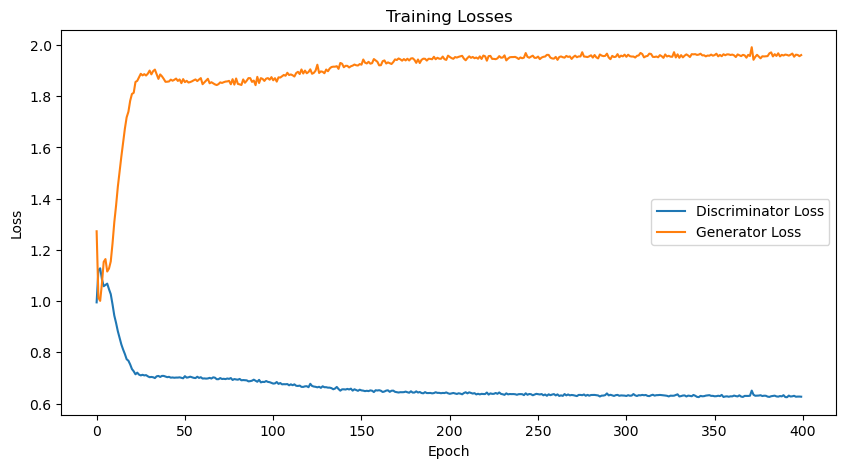

In [21]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [23]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [24]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

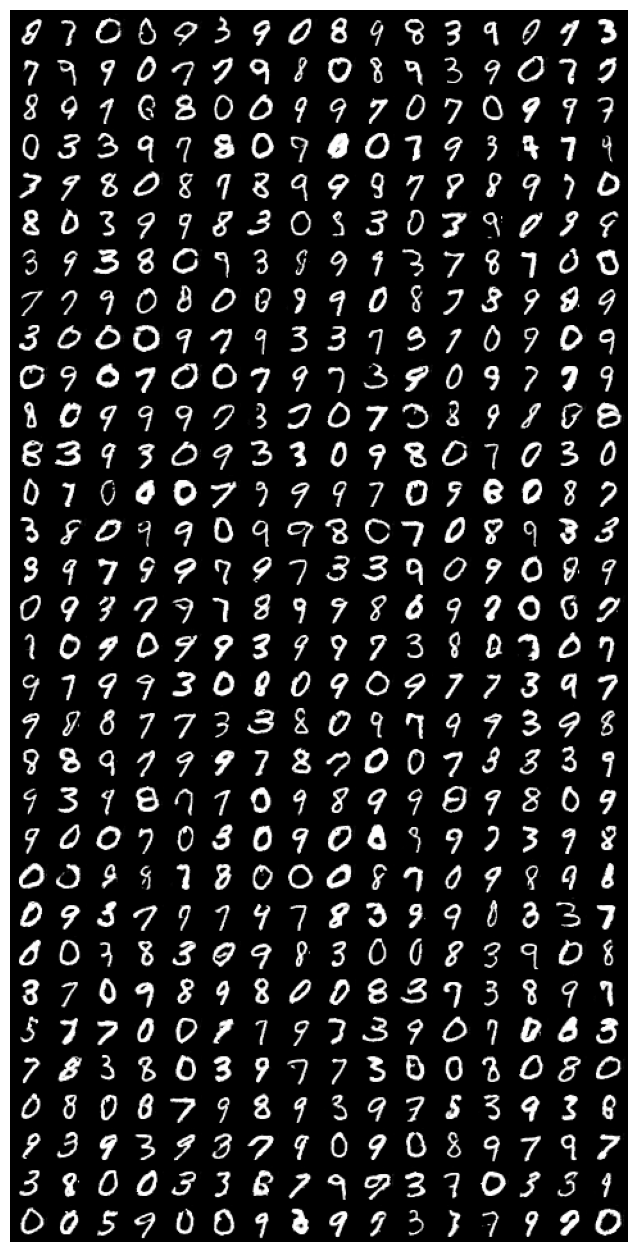

In [27]:
# Generate noise vectors
batch_size = 512  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(16, 16))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
